#  <span style="color:blue">Tutorial - Extended Kalman Filter</span>

This tutorial implements an extended Kalman filter for a differential drive robot using Python. The learning outcomes are:
- Understand how uncertainty modelling is achieved in the EKF, and the impact of process and measurement noise parameters
- Be able to implement and apply an EKF to a simple robotic scenario

There are many practical aspects that are hard to understand from the theory, mainly:
- How to handle timestamps from seperate sensors
- Dealing with angle wrapping where needed (same as when we interpolated angle in `time and motion`) to avoid numerical averaging artifacts (average $1^o$ and $359^o$ is $0^o$, but without handling wrapping it would be  $180^o$ which is incorrect)

    
Classes and functions defined in this section are also contained in the course libraries `model_feeg6043.py` and `math_feeg6043.py` and `plot_feeg6043.py` libraries, where we will also use function already defined in these libraries from earlier in the course. The figure below gives an overview of what we will cover.

<img src="images/A2_1_Tutorial_Overview.png" alt="Tutorial Overview" width="800px" align="center"/>    

## 1. Extended Kalman Filter (EKF)

Implement the EKF algorithm as predict and update functions below.

<img src="images/ekf_steps.png" width="800"/>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math_feeg6043 import Vector, Matrix, Identity, Inverse, eigsorted, gaussian, l2m
from matplotlib.patches import Ellipse
from plot_feeg6043 import plot_kalman, plot_EKF_trajectory

def extended_kalman_filter_predict(mu, Sigma, u, f, R, dt):
    # (1) Project the state forward
    # f is the rigid body motion model
    pred_mu, F = f(mu, u, dt)
      
    # (2) Project the error forward: 
    pred_Sigma = (F @ Sigma @ F.T) + R
    
    # Return the predicted state and the covariance
    return pred_mu, pred_Sigma

def extended_kalman_filter_update(mu, Sigma, z, h, Q, wrap_index = None):
    
    # Prepare the estimated measurement
    pred_z, H = h(mu)
 
    # (3) Compute the Kalman gain
    K = Sigma @ H.T @ np.linalg.inv(H @ Sigma @ H.T + Q)
    
    # (4) Compute the updated state estimate
    delta_z = z- pred_z        
    if wrap_index != None: delta_z[wrap_index] = (delta_z[wrap_index] + np.pi) % (2 * np.pi) - np.pi    
    cor_mu = mu + K @ (delta_z)

    # (5) Compute the updated state covariance
    cor_Sigma = (np.eye(mu.shape[0], dtype=float) - K @ H) @ Sigma
    
    # Return the state and the covariance
    return cor_mu, cor_Sigma

### Tiniest EKF example you can think of
The cell below implements a simple EKF on a non-linear function

If $f(\mathbf{x}_{k}) = \mathbf{x}^2_{k-1}+\mathbf{u}_k$, and $h(\mathbf{x}_{k}) = \mathbf{x}_{k}$ we have:

Motion model: $ \left\lbrace \begin{aligned}
\mathbf{x}_k &=& \mathbf{x}^2_{k-1} + \mathbf{u}_k + \epsilon_k\\
R_k &=& \epsilon^2_k
\end{aligned}\right.$

Observation model $ \left\lbrace \begin{aligned}
\mathbf{z}_{k} &=& \mathbf{x}_{k} + \delta_k\\
Q_k &=& \delta^2_k
\end{aligned}\right.$

Create the functions below to model these and determine the Jacobians of these where

$F = \dfrac{df}{d\mathbf{x}}$

and 

$H = \dfrac{dh}{d\mathbf{x}}$

In [3]:
def f_nonlin(x, u, dt):
    # this is a non-linear model that cannot be solved with a KF f(x)=x**2+u
    F = np.zeros((1, 1), dtype=float)
    F[0,0] = 2*x
    return x ** 2 + u , F

def h(x):
    H = Matrix(1,1)
    H[0,0] = 1
    return x, H

Start with:

> **Task 1:** Make a prediction from a previous state belief $[\mu,\Sigma]=[0,1]$ 
> Control vector $u=2$ with process noise $R = 2$ applied for $dt=1$
>
> **Task 2:** Add a measurement of $z=2$ with measurement noise $Q = 1$
>
> **Task 3:** Worst sensor ever - make measurement noise $Q = 10^{10}$
>
> **Task 4:** Good sensor - make measurement noise $Q = 10^{-10}$

We import a library version of `extended_kalman_filter_predict` and `extended_kalman_filter_update` that are identical to above but have the following keyword arguments
> view_flag -- A boolean to show intermediate plots of the prediction and measurement update - only implemented for 1D examples

C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\295897735.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[0,0] = 2*x


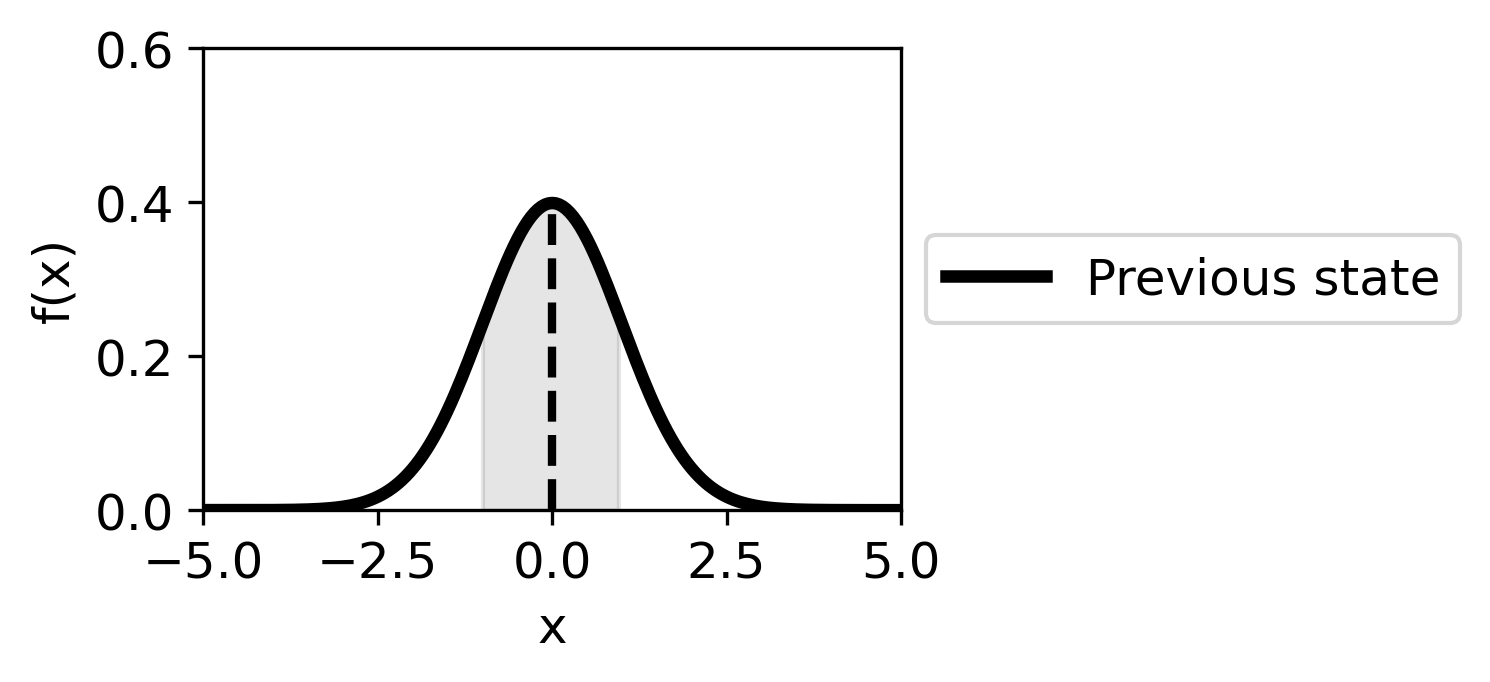

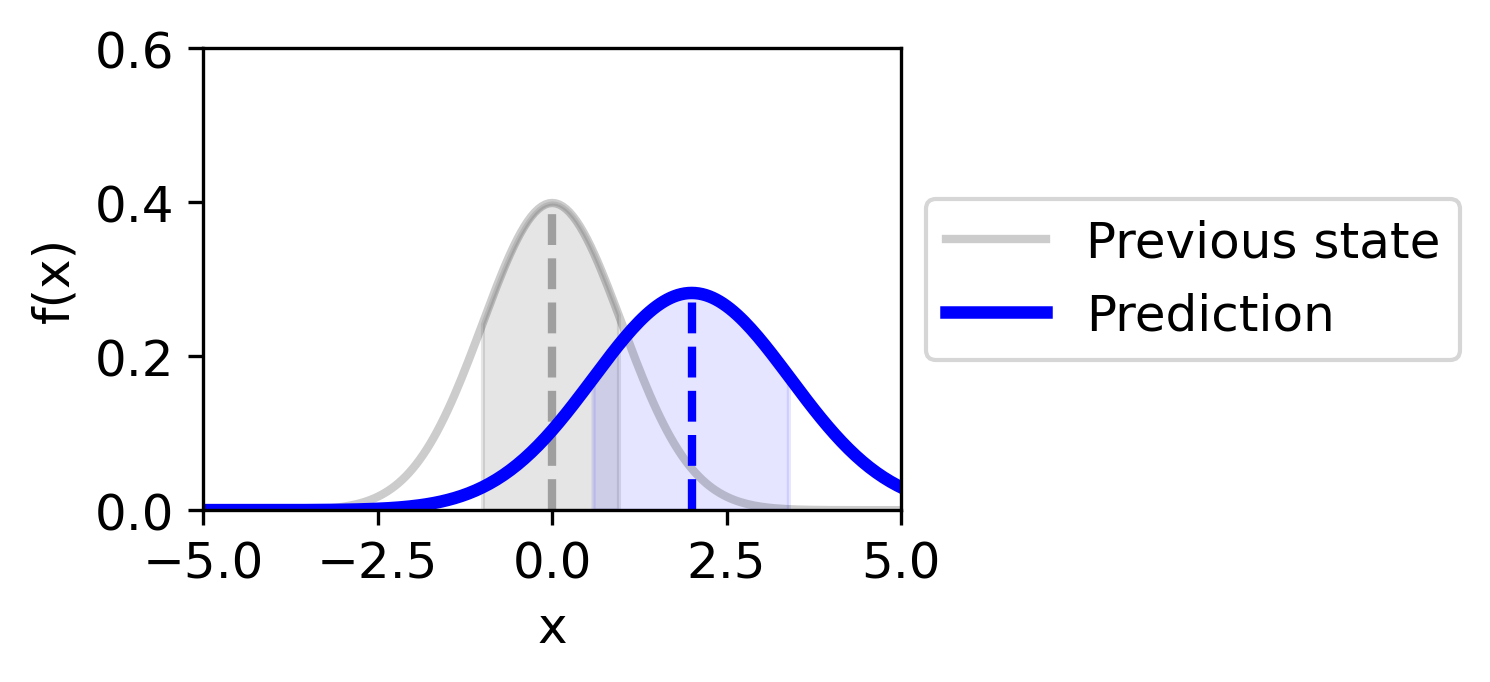

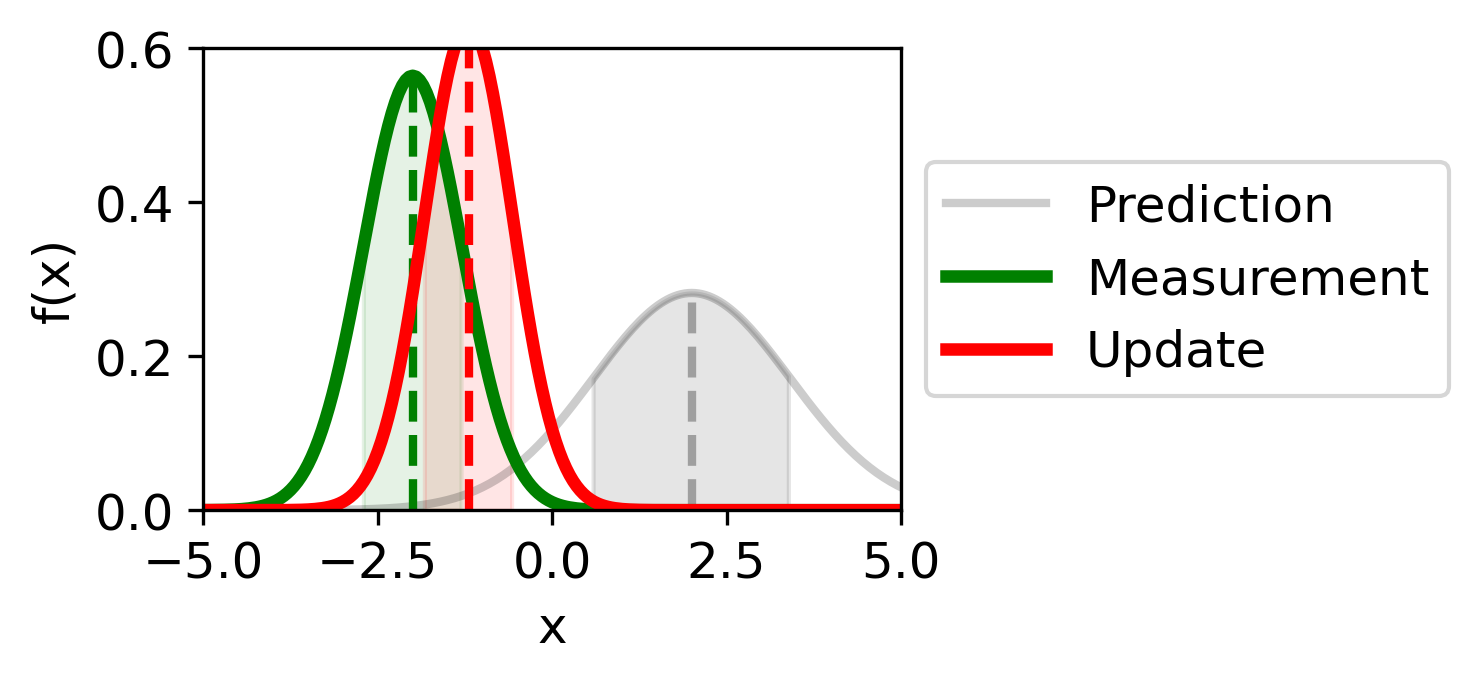

Control: u =[[2.]], Process noise: R =[[2.]]
Observation: z =[[-2.]], Measurement noise: Q =[[0.5]]
Previous state : mu =[[0.]], Sigma=[[1.]]
Prediction: mu =[[2.]], Sigma=[[2.]]
Correction: mu =[[-1.2]], Sigma=[[0.4]]


In [4]:
from model_feeg6043 import extended_kalman_filter_predict, extended_kalman_filter_update

#v define a zero matrix and a one matrix
zm = Matrix(1,1)
om = Matrix(1,1); 
om[0,0] = 1

# Previous belief and timestep
state = zm 
covariance = om 
dt = 1

# Set control and process noise
u = 2*om
R = 2*om

# Set measurement and measurement noise 
z = -2*om

# Task 2 -  Terrible sensor (high measurement noise)
Q = np.multiply(10E10,om); 
view_flag = True
# Task 3 - Good sensor (low measurement noise, 
# no need to rely on the prediction since the measurement is so good)

Q = np.multiply(0.5,om)
# Task 4 ??

pred_state, pred_covariance = extended_kalman_filter_predict(state, covariance, u, f_nonlin, R, dt,view_flag=view_flag)

# Task 2
cor_state, cor_covariance =  extended_kalman_filter_update(pred_state, pred_covariance, z, h, Q,view_flag=view_flag)

print('Control: u =' + str(u) + ', Process noise: R =' + str(R))
print('Observation: z =' + str(z) + ', Measurement noise: Q =' + str(Q))
print('Previous state : mu =' + str(state) + ', Sigma=' + str(covariance))
print('Prediction: mu =' + str(pred_state) + ', Sigma=' + str(pred_covariance))
# Task 2
print('Correction: mu =' + str(cor_state) + ', Sigma=' + str(cor_covariance))

Next we put this into a small loop to demonstrate prediction and update behaviour to a sequence of observations

> z = [0.5, 1.0] at t = [2, 4]s with Q = 2

with

> u = 0.5 with R = 2

- **Task 1:** Run this with just the prediction step
- **Task 2:** Next run it with the update as well

C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\295897735.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[0,0] = 2*x


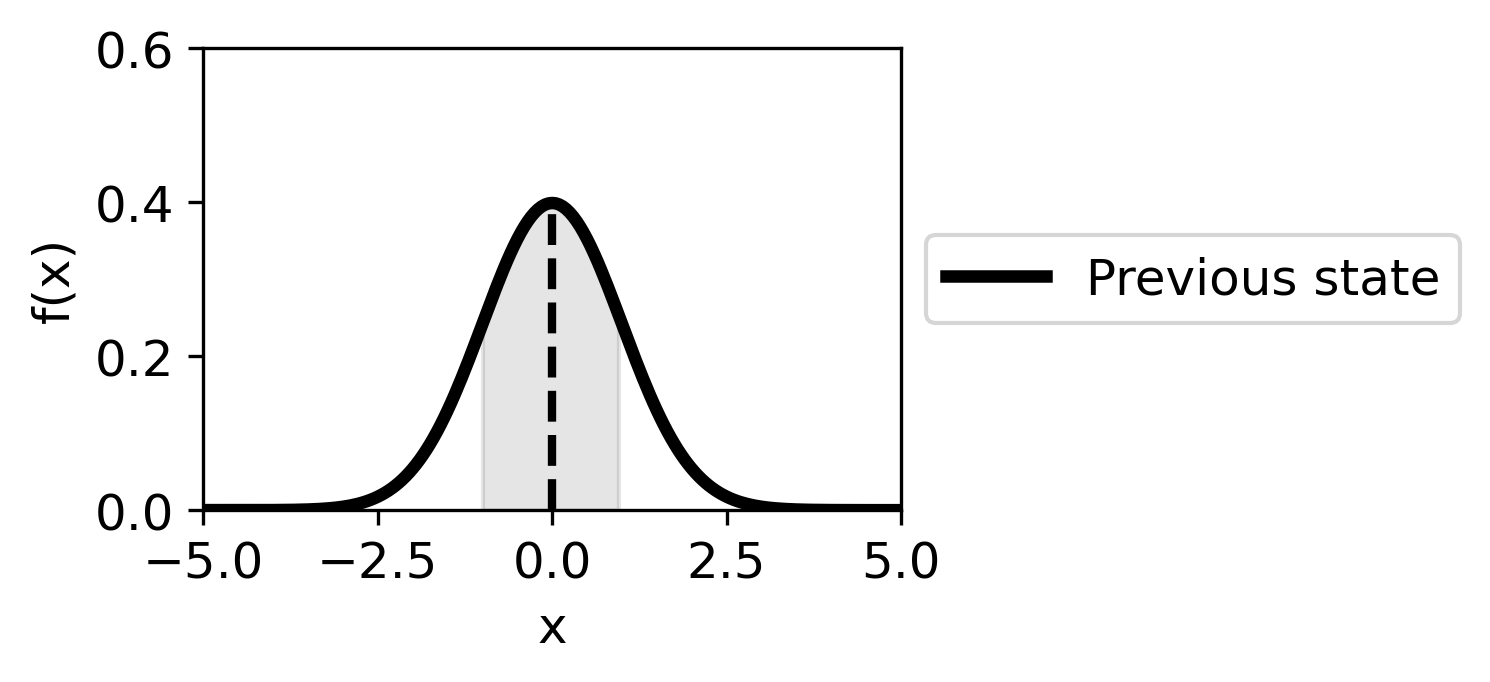

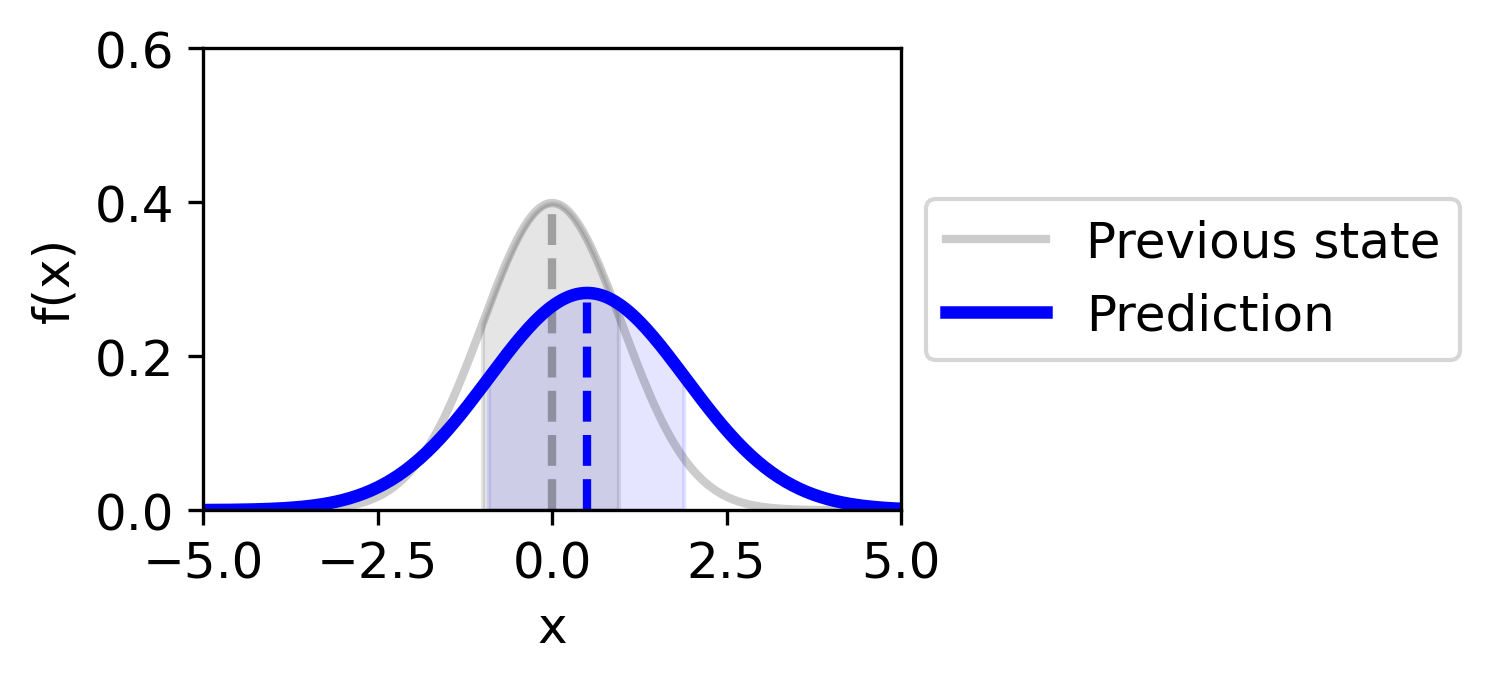

Time is [1.] s control is 0.5 state is [[0.5]] covariance is [[2.]]


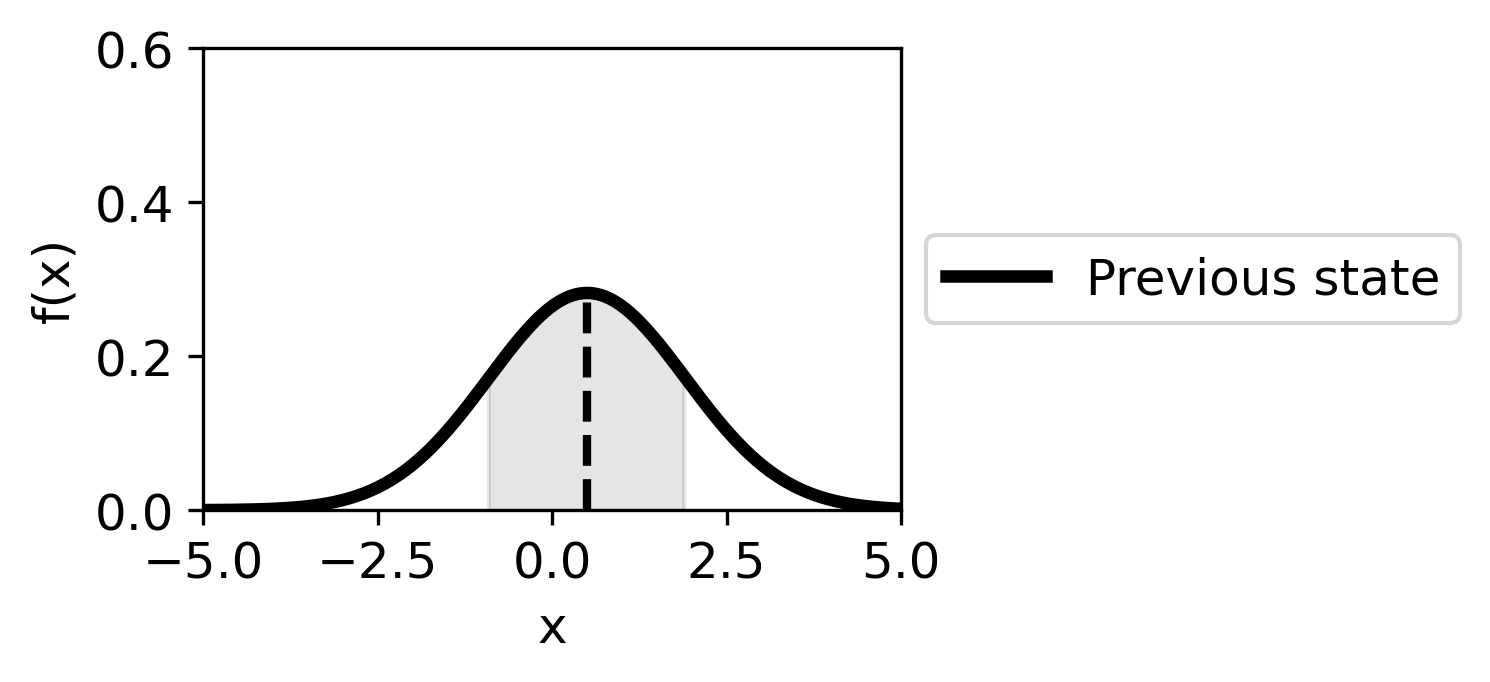

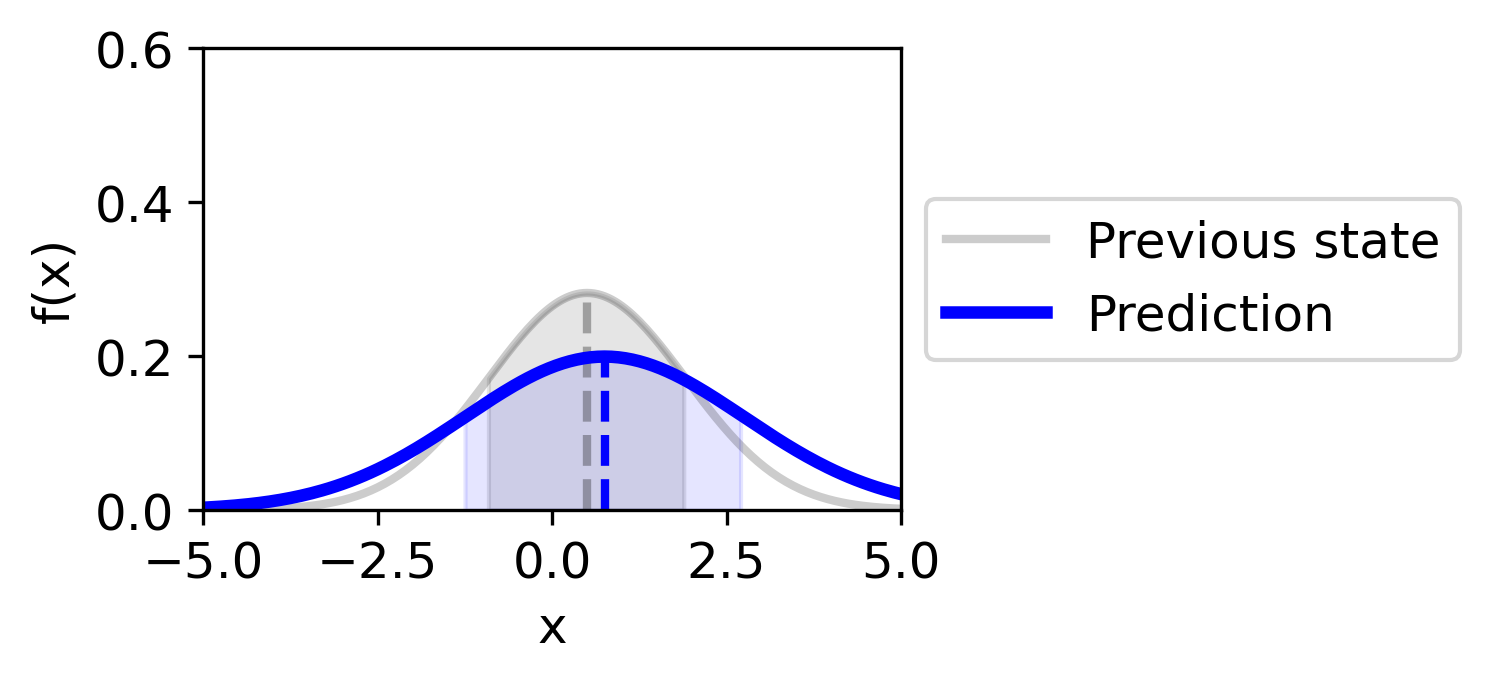

Time is [2.] s control is 0.5 state is [[0.75]] covariance is [[4.]]


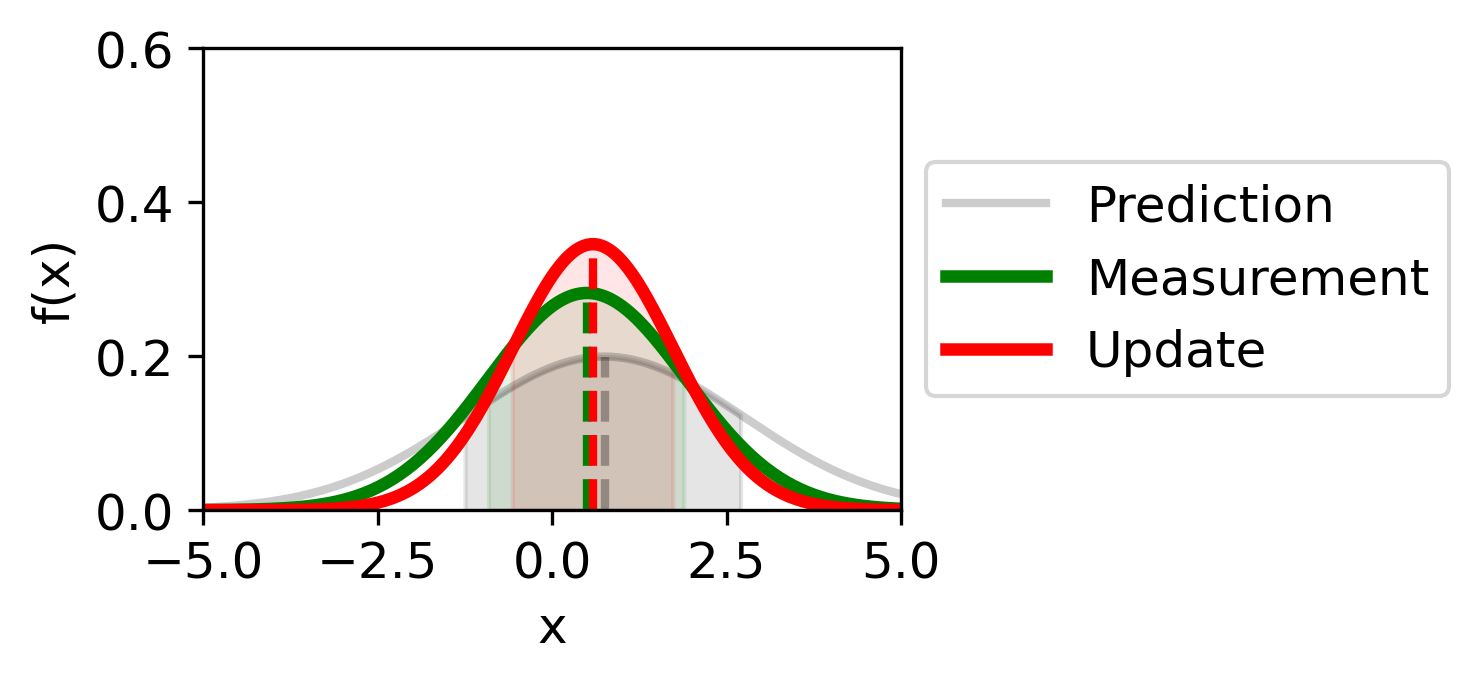

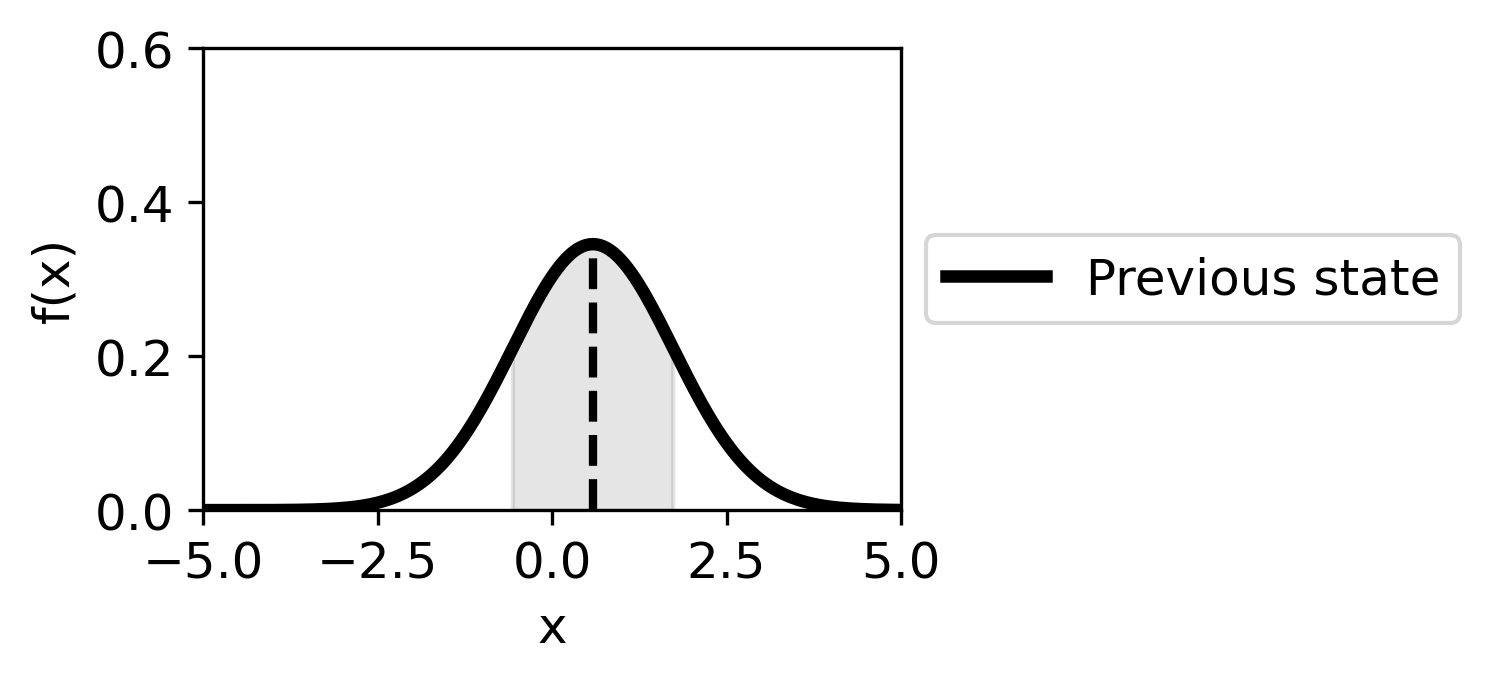

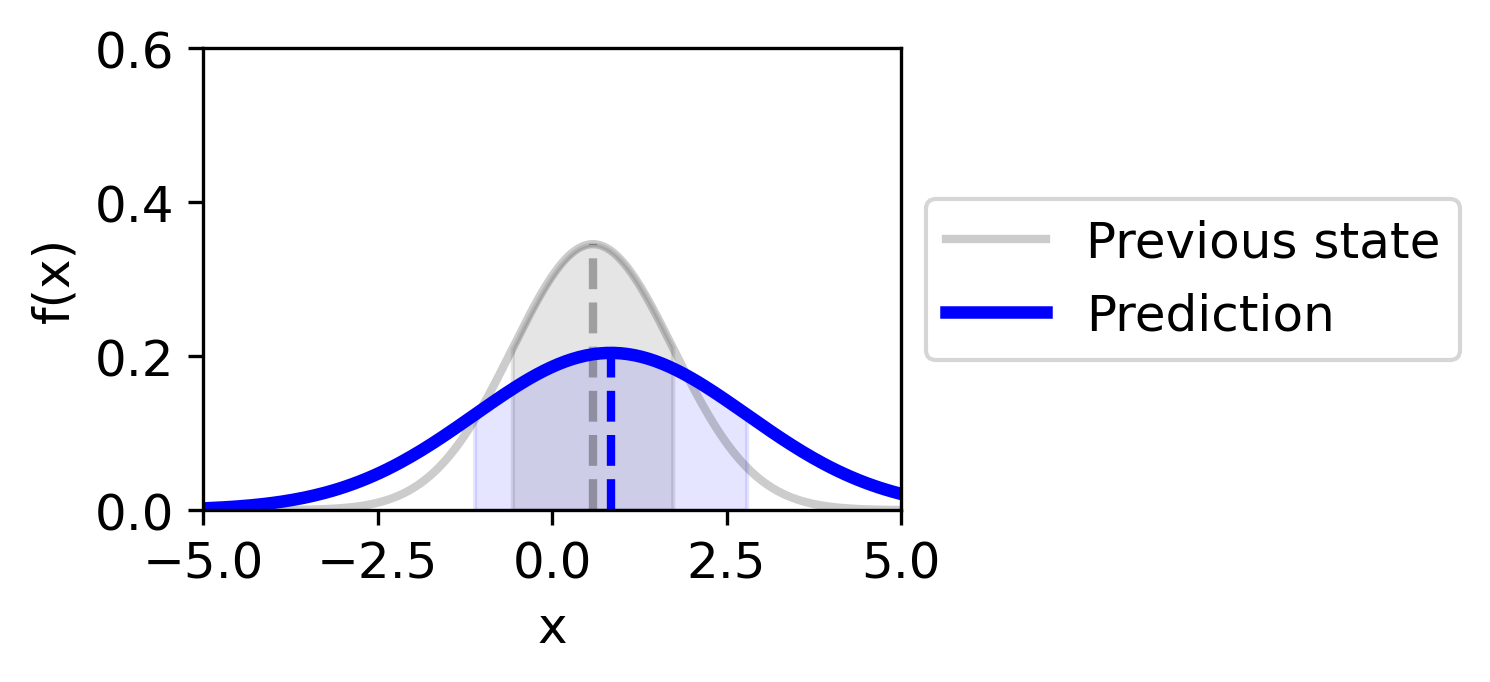

Time is [3.] s control is 0.5 state is [[0.84027778]] covariance is [[3.81481481]]


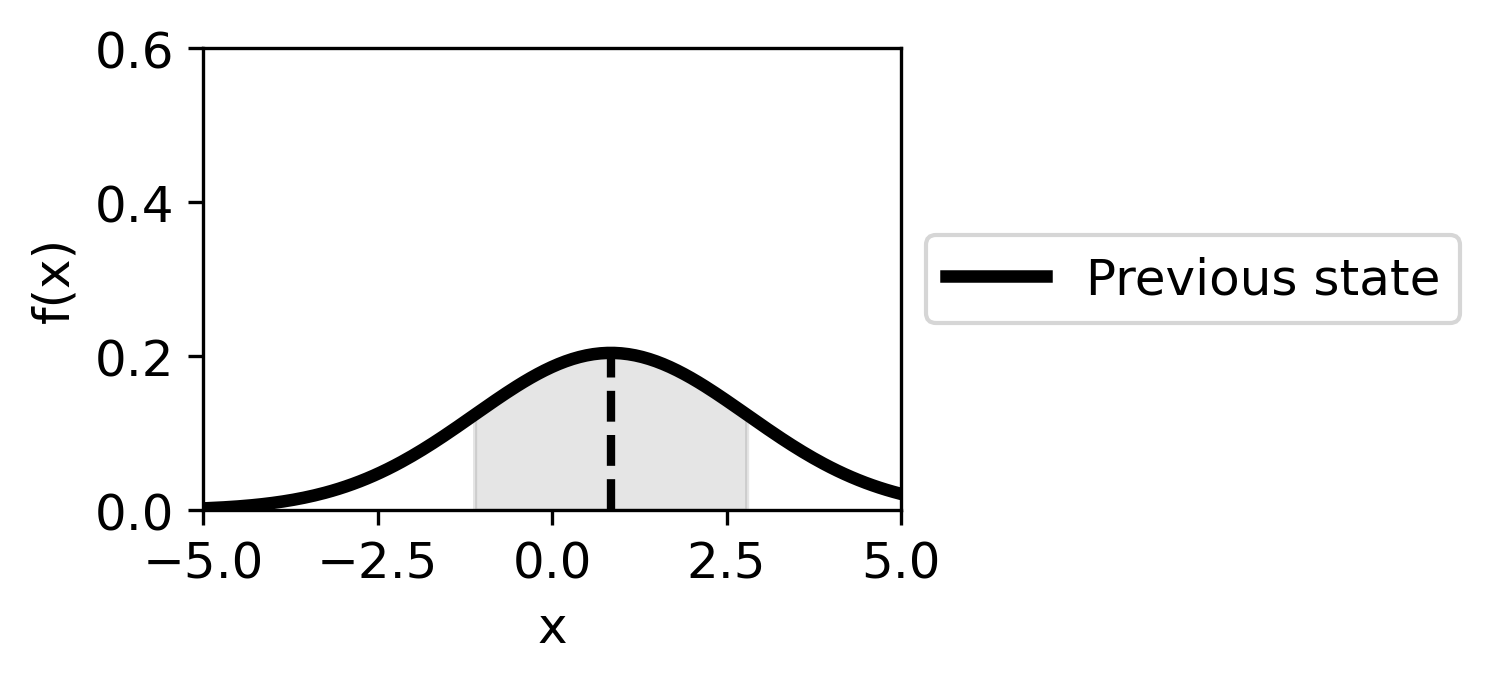

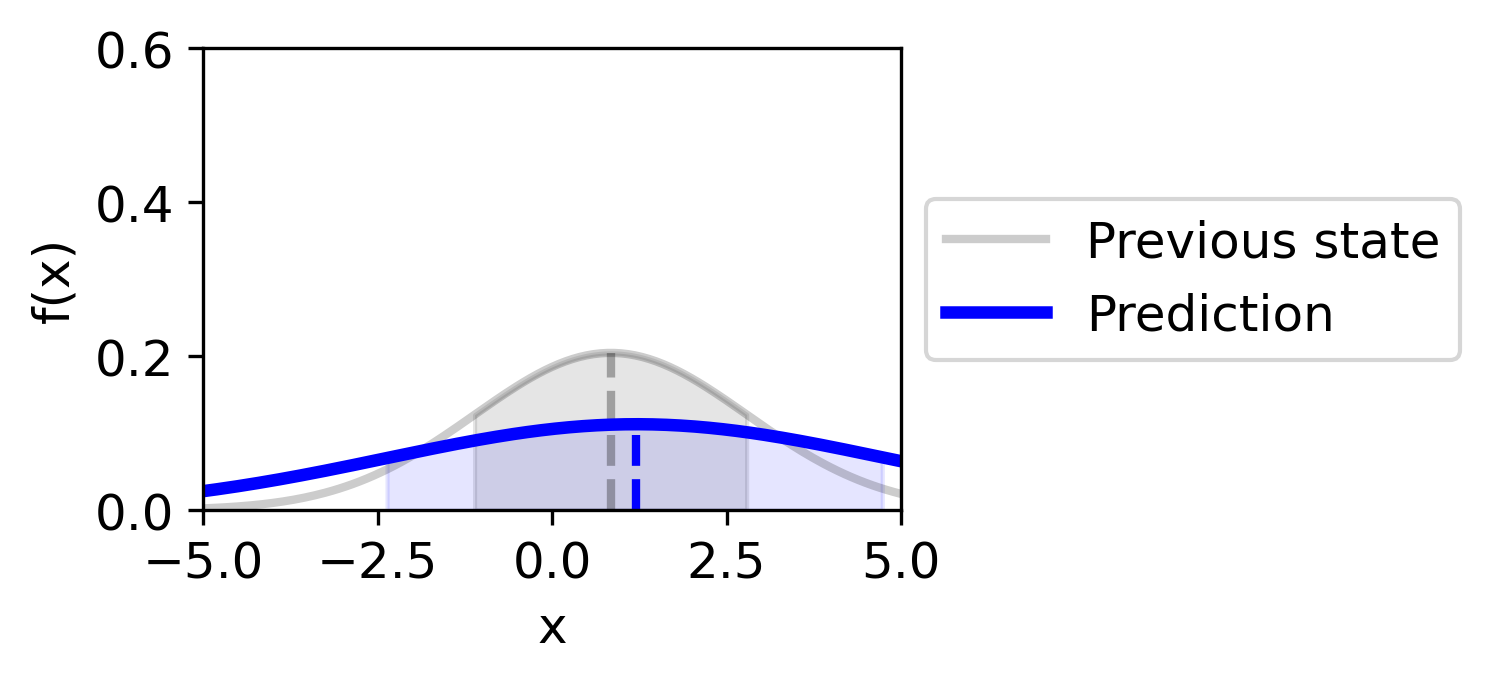

Time is [4.] s control is 0.5 state is [[1.20606674]] covariance is [[12.7740555]]


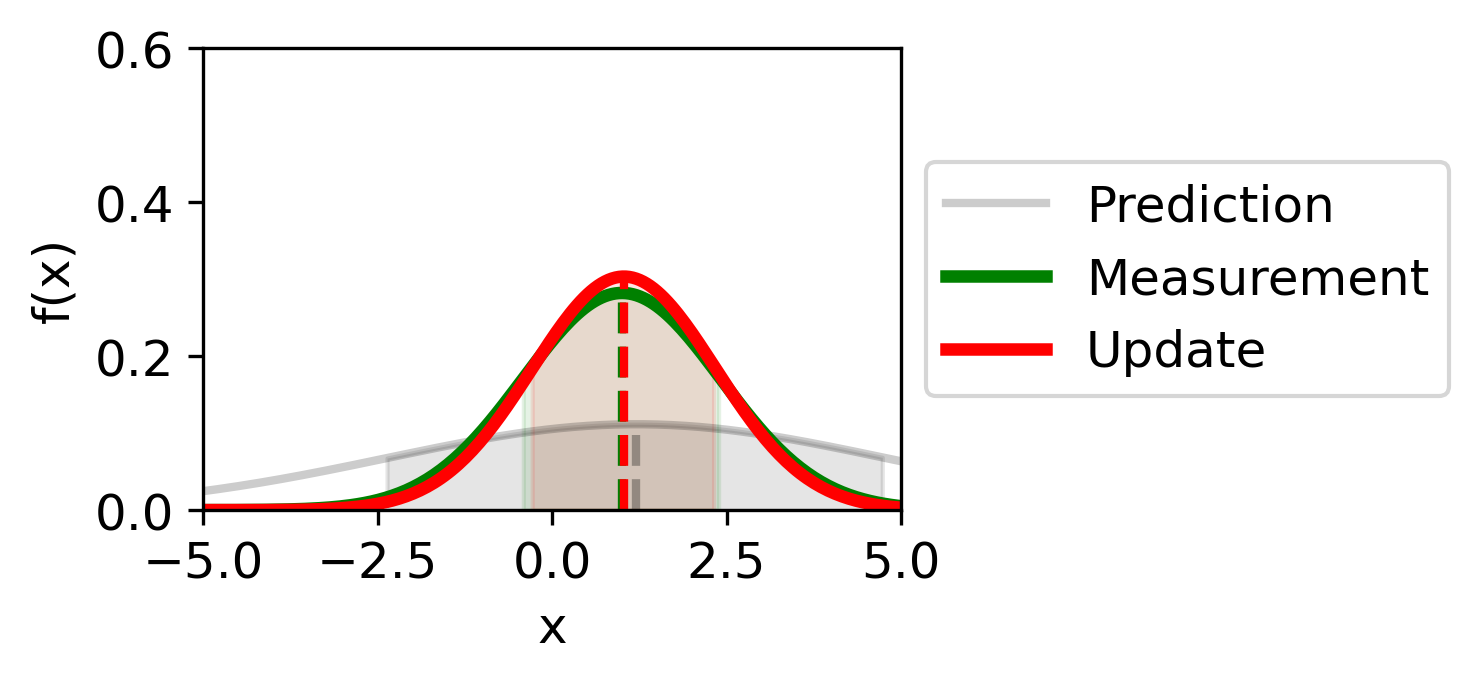

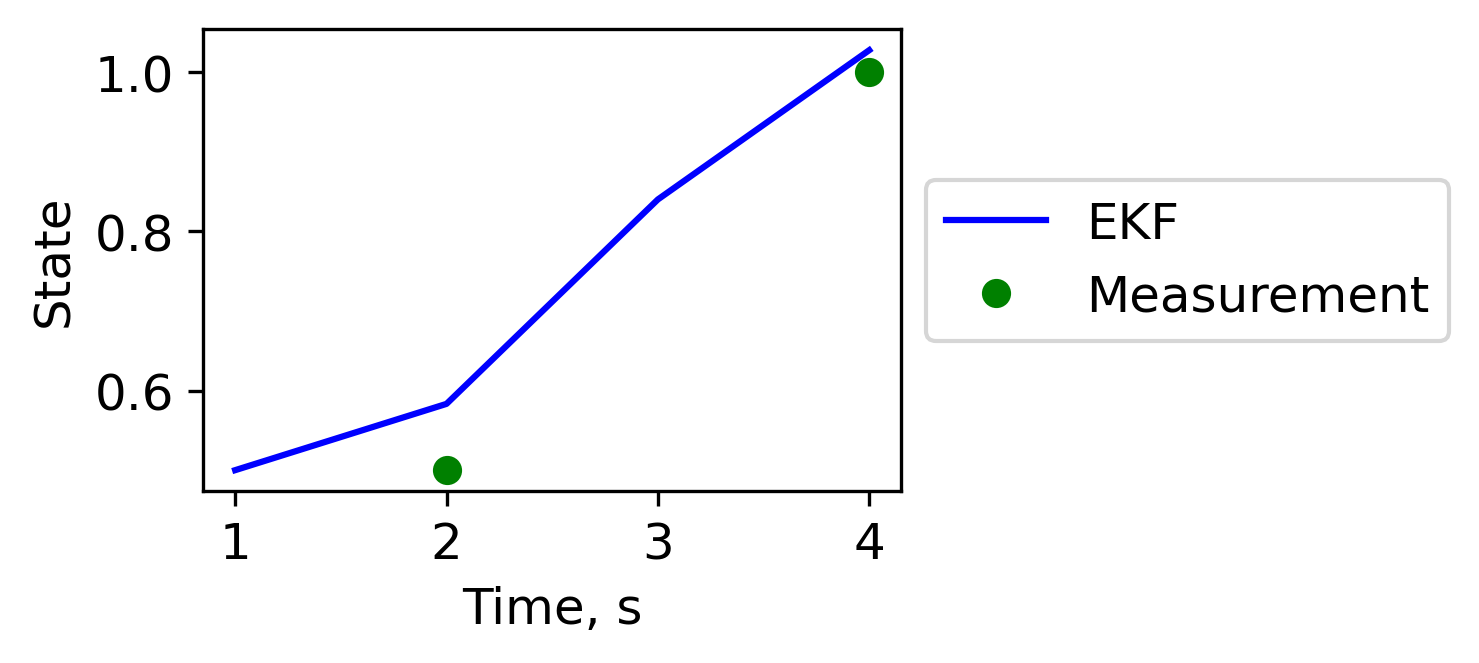

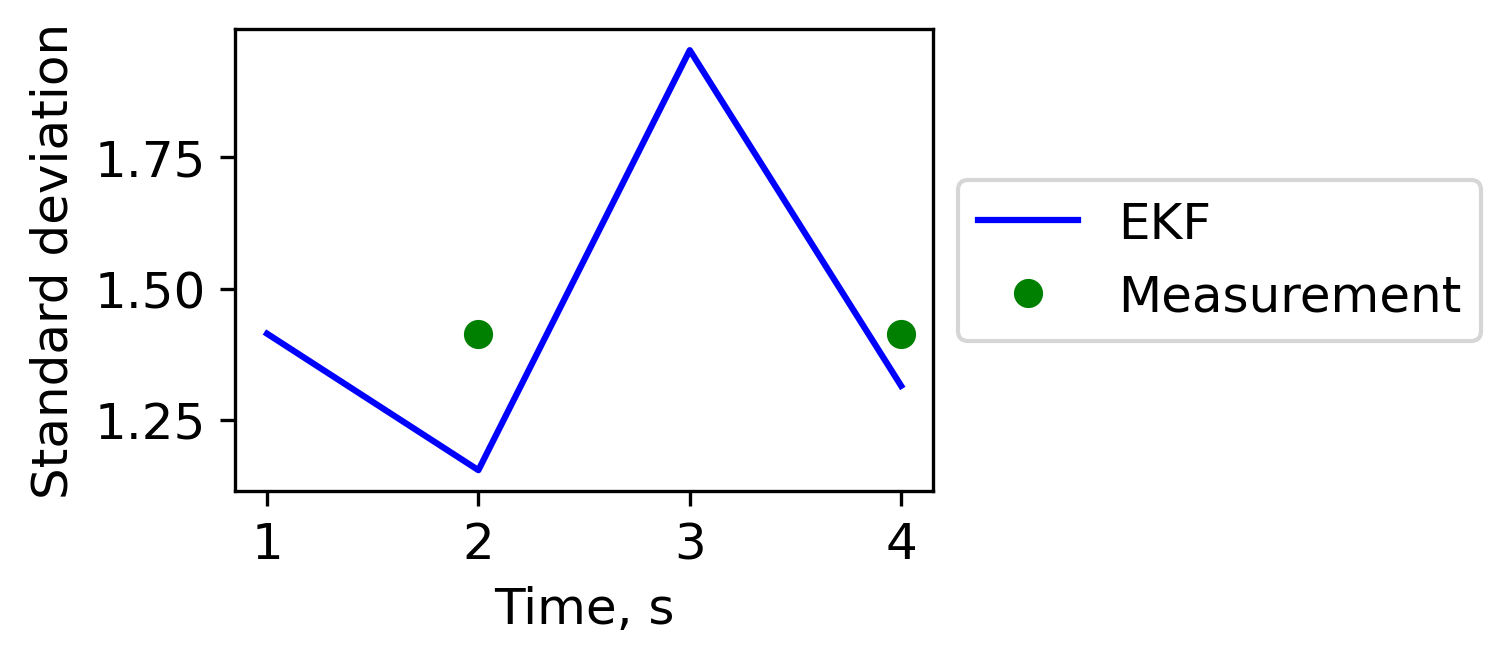

In [5]:
###################################################################
# Create some timestamps to simulate between
###################################################################
start = 1
end = 4
dt = 1
num_points = int( (end - start) / dt )+1
t_list = np.linspace(start, end, num_points)
# create a containor
T = l2m(t_list)
###################################################################
# Set control and process noise
###################################################################
u = 0.5
R = 2

###################################################################
# Set measurement updates and measurement noise
###################################################################
z_list = [0.5, 1.0]
Z = l2m(z_list)
tz_list = [2, 4]
Q = 2*om
idx = 0 #initial pointer to check for sensor measurements
###################################################################
# Previous belief and timestep
###################################################################
state = zm
covariance = om 
t_prev=0


X = Vector(0)
COV = Vector(0)

#################################################################
# Main simulation loop
#################################################################
for i in range(len(T)):

    # get next timestamp to model to and compute time interval ()
    t=T[i]
    dt = t-t_prev
    
    # state, covariance = ?? # Task 1
    state, covariance = extended_kalman_filter_predict(state, covariance, u, f_nonlin, R, dt, view_flag=True)
    print('Time is', t, 's', 'control is', u, 'state is', state, 'covariance is', covariance)
    
    if t == tz_list[idx]:
        z = Z[idx:idx+1]  # extracts the idx row of the matrix Z       
        # state, covariance = ?? # Task 2
        state, covariance = extended_kalman_filter_update(state, covariance, z, h, Q, view_flag=True)
        if idx < len(tz_list)-1: idx+=1        
   
    # store state and covariance
    X = np.vstack((X, state))
    COV = np.vstack((COV, covariance))
    
    # store timestamp to calculate dt
    t_prev = t
    

#################################################################
# Plot results
#################################################################

plt.plot(T, X,'b-',label='EKF')
plt.plot(tz_list, z_list,'go',label='Measurement')
plt.xlabel('Time, s'), plt.ylabel('State')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); plt.show()


plt.plot(T, np.sqrt(COV),'b-',label='EKF')
plt.xlabel('Time, s'), plt.ylabel('Standard deviation')
plt.plot(tz_list, np.multiply(np.ones_like(tz_list),np.sqrt(Q[0,0])),'go',label='Measurement')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); plt.show()


## <span style="color:blue"> 2. Motion model (Predict prior)</span>

Implements EKF for 2D rigid-body vehicle kinematics with the following state vector:

$$ \mathbf{x} = (N, E, \gamma , \dot x, \dot \gamma) $$

where,

* $N$ is the northing position (frame $e$) in metres
* $E$ is the easting position (frame $e$) in metres
* $\gamma$ is the heading (frame $e$) in radians
* $\dot x$ is the forward speed (frame $b$) in m/s
* $\dot \gamma$ is the angular rate (frame $b$ and $e$) rad/s

where the kinematic motion model $f(\mathbf{x}_{k})$ for **twist motion** is defined as:

\begin{aligned}
\mathbf{x}_{k} = f(\mathbf{x}_{k-1},\mathbf{u}_{k}) = \left\lbrace \begin{array}{l}
f_0(\mathbf{x}_{k-1},\mathbf{u}_{k}) = N_{k} &=& N_{k-1}  -\frac{\dot{x}_k}{\dot{\gamma}_k} \sin \gamma_{k-1} +\frac{\dot{x}_k}{\dot{\gamma}_k}  \sin (\gamma_{k-1} + {\dot{\gamma}_k}\Delta t_k) \\
f_1(\mathbf{x}_{k-1},\mathbf{u}_{k}) = E_{k} &=& E_{k-1} + \frac{\dot{x}_k}{\dot{\gamma}_k} \cos \gamma_{k-1} - \frac{\dot{x}_k}{\dot{\gamma}_k} \cos (\gamma_{k-1} + \dot{\gamma}_k\Delta t_k) \\
f_2(\mathbf{x}_{k-1},\mathbf{u}_{k}) = \gamma_{k} &=&  \gamma_{k-1} + \dot \gamma_{k}\Delta t_k \\
f_3(\mathbf{x}_{k-1},\mathbf{u}_{k}) = \dot x_{k} &=& v \\
f_4(\mathbf{x}_{k-1},\mathbf{u}_{k}) = \dot \gamma_{k} &=& \omega \end{array} \right. 
\end{aligned}

and its Jacobian ${F}_{k}$ is:

\begin{aligned}
F_k=\begin{bmatrix}
1 & 0 & \frac{\dot{x}_k}{\dot{\gamma}_k}(\cos\gamma_{k} - \cos\gamma_{k-1}) & \frac{1}{\dot{\gamma}_k} (\sin\gamma_{k} - \sin\gamma_{k-1}) & \frac{\dot{x}_k}{\dot{\gamma}^2_k} (\sin\gamma_{k-1} - \sin\gamma_{k}) + \frac{\dot{x}_k\Delta t_k}{\dot{\gamma}_k}\cos\gamma_k\ \\
0 & 1 & \frac{\dot{x}_k}{\dot{\gamma}_k} (\sin\gamma_{k} -\sin\gamma_{k-1})& \frac{1}{\dot{\gamma}_k} (\cos\gamma_{k-1} - \cos\gamma_{k}) & \frac{\dot{x}_k}{\dot{\gamma}^2_k} (\cos\gamma_{k}-\cos\gamma_{k-1}) + \frac{\dot{x}_k\Delta t_k}{\dot{\gamma}_k}\sin\gamma_{k} \\
0 & 0 & 1 & 0 & \Delta t_k \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
\end{aligned}

where we need to handle the exception when when $w=0$ (i.e., **linear motion**)), where our motion and Jacobian simplify to the following forms:

\begin{aligned}
\mathbf{x}_{k} = f(\mathbf{x}_{k-1},\mathbf{u}_{k}) = \left\lbrace \begin{array}{l}
f_0(\mathbf{x}_{k-1},\mathbf{u}_{k}) = N_{k} &=& N_{k-1}  + \dot{x}_k\Delta t_k \cos \gamma_{k-1} \\
f_1(\mathbf{x}_{k-1},\mathbf{u}_{k}) = E_{k} &=& E_{k-1} + \dot{x}_k\Delta t_k \sin \gamma_{k-1} \\
f_2(\mathbf{x}_{k-1},\mathbf{u}_{k}) = \gamma_{k} &=&  \gamma_{k-1} + \dot{\gamma}_k\Delta t_k \\
f_3(\mathbf{x}_{k-1},\mathbf{u}_{k}) = \dot x_{k} &=& v \\
f_4(\mathbf{x}_{k-1},\mathbf{u}_{k}) = \dot \gamma_{k} &=& w \end{array} \right. 
\end{aligned}

and its jacobian ${F}_{k}$ is:

\begin{aligned}
F_k=\begin{bmatrix}
1 & 0 & -\dot{x}_k \Delta t_k \sin\gamma_{k-1} & \Delta t_k \cos\gamma_{k-1}  & 0 \\
0 & 1 & \dot{x}_k \Delta t_k \cos\gamma_{k-1} & \Delta t_k \sin\gamma_{k-1}  & 0 \\
0 & 0 & 1 & 0 & \Delta t_k \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
\end{aligned}

Implement the motion model and compute the Jacobian in the cell below.

In [6]:
from model_feeg6043 import rigid_body_kinematics

# Easy names for indexing
N = 0
E = 1
G = 2
DOTX = 3
DOTG = 4

def motion_model(state, u, dt):
        
    N_k_1 = state[N]
    E_k_1 = state[E]
    G_k_1 = state[G]
    DOTX_k_1 = state[DOTX]
    DOTG_k_1 = state[DOTG]

    p = Vector(3)
    p[0] = N_k_1
    p[1] = E_k_1
    p[2] = G_k_1
    
    # note rigid_body_kinematics already handles the exception dynamics of w=0
    p = rigid_body_kinematics(p,u,dt)    

    # vertically joins two vectors together
    state = np.vstack((p, u))
    
    N_k =  state[N]
    E_k = state[E]
    G_k = state[G]
    DOTX_k = state[DOTX]
    DOTG_k =  state[DOTG]
    
    # Compute its jacobian
    F = Identity(5)    
    
    if abs(DOTG_k) <1E-2: # caters for zero angular rate, but uses a threshold to avoid numerical instability
        F[N, G] = -DOTX_k * dt *np.sin(G_k_1)
        F[N, DOTX] = dt * np.cos(G_k_1)
        F[E, G] = DOTX_k * dt * np.cos(G_k_1)
        F[E, DOTX] = dt * np.sin(G_k_1)
        F[G, DOTG] = dt     
        
    else:
        F[N, G] = (DOTG_k/DOTG_k)*(np.cos(G_k)-np.cos(G_k_1))
        F[N, DOTX] = (1/DOTG_k)*(np.sin(G_k)-np.sin(G_k_1))
        F[N, DOTG] = (DOTX_k/(DOTG_k**2))*(np.sin(G_k_1)-np.sin(G_k))+(DOTX_k*dt/DOTG_k)*np.cos(G_k)
        F[E, G] = (DOTX_k/DOTG_k)*(np.sin(G_k)-np.sin(G_k_1))
        F[E, DOTX] = (1/DOTG_k)*(np.cos(G_k_1)-np.cos(G_k))
        F[E, DOTG] = (DOTX_k/(DOTG_k**2))*(np.cos(G_k)-np.cos(G_k_1))+(DOTX_k*dt/DOTG_k)*np.sin(G_k)
        F[G, DOTG] = dt

    return state, F

### <span style="color:blue">Sanity check the motion model</span>

Try some easy conditions:
- **Task 1** Forward motion v=1m/s with $\gamma=0$ *(needs to be in rad)*
- **Task 2** Forward motion v=1m/s with $\gamma=90$ *(needs to be in rad)*
- **Task 3** Forward motion v=1m/s with $\dot \gamma=90$ *(needs to be in rad/s)*

In [7]:
dt = 1.0 # set timestep

#########################################################
# modify the orientation here
#########################################################
state = Vector(5) # initialise state
state[G] = np.deg2rad(90)  #rad #initial orientation

#########################################################
# modify the control inputs
#########################################################
u = Vector(2) # set timestep
u[0] = 1 #m/s
u[1] = np.deg2rad(90) #rad/s # rate of change of heading

print('previous state\n',state)
print('control\n',u)

#########################################################
# motion model
#########################################################
state, F = motion_model(state, u, dt)

print('predicted state (prior)\n',state)
print('Jacobian\n',F)

previous state
 [[0.        ]
 [0.        ]
 [1.57079633]
 [0.        ]
 [0.        ]]
control
 [[1.        ]
 [1.57079633]]
predicted state (prior)
 [[-0.63661977]
 [ 0.63661977]
 [ 3.14159265]
 [ 1.        ]
 [ 1.57079633]]
Jacobian
 [[ 1.          0.         -1.         -0.63661977 -0.23133504]
 [ 0.          1.         -0.63661977  0.63661977 -0.40528473]
 [ 0.          0.          1.          0.          1.        ]
 [ 0.          0.          0.          1.          0.        ]
 [ 0.          0.          0.          0.          1.        ]]


C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3751406531.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[N, G] = (DOTG_k/DOTG_k)*(np.cos(G_k)-np.cos(G_k_1))
C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3751406531.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[N, DOTX] = (1/DOTG_k)*(np.sin(G_k)-np.sin(G_k_1))
C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3751406531.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[N, DOTG] = (DOTX_k/

### <span style="color:blue">Create a set of controls</span>

Create a set of controls:
> Go forwards 10s, at 2m/s
> Stop and turn 90degrees in 4s
> Go forwards again for 10s, etc, repeating to complete a square

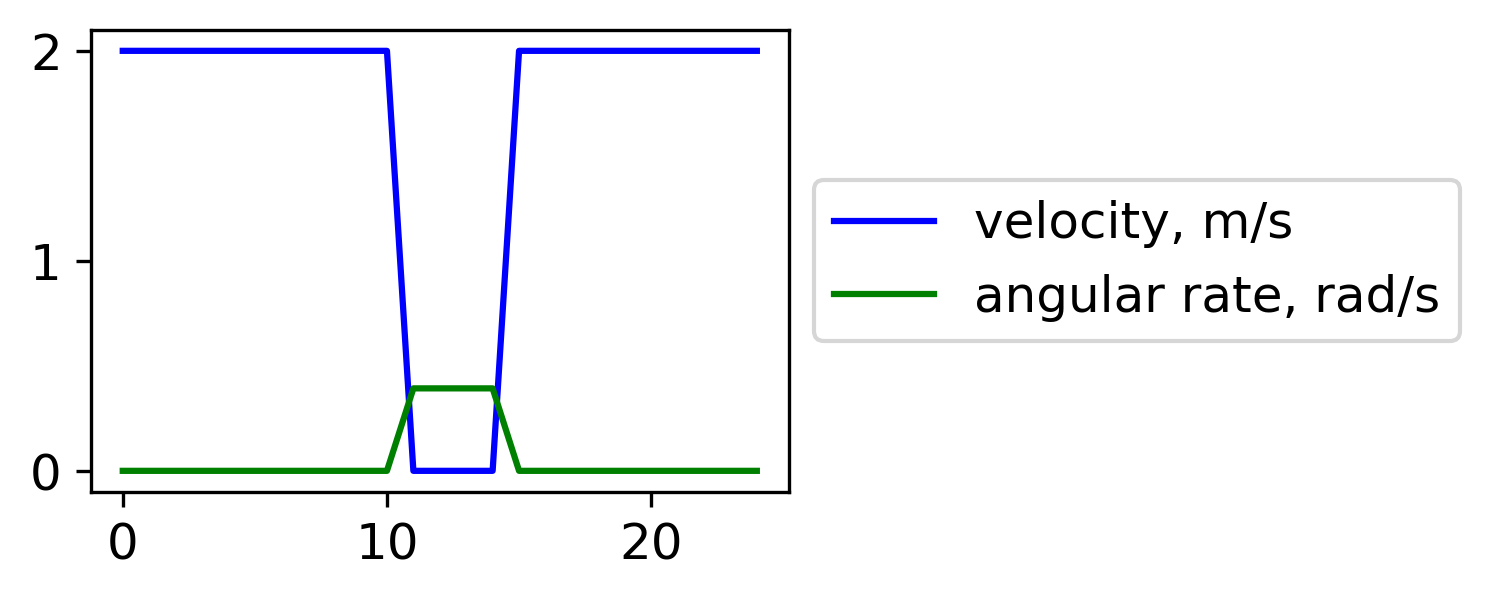

In [8]:
start = 0
end = 24
timestep = 1 #s
num_points = int( end / timestep )+1
t_list = np.linspace(start, end, num_points)
v_list = []
w_list = []
for i in range(len(t_list)):
    if t_list[i] <= 10:
        v_list.append(2)
        w_list.append(0)
    elif t_list[i] <= 14:
        v_list.append(0)
        w_list.append(np.deg2rad(90/4)) # want to turn 90degrees in 4s
    else:
        v_list.append(2)
        w_list.append(0)   
    
T_u = l2m(t_list)
U = l2m([v_list,w_list])

plt.plot(T_u,U[:,0],'b-',label = 'velocity, m/s') #all rows at column 0 
plt.plot(T_u,U[:,1],'g-',label = 'angular rate, rad/s')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); plt.show()

- **Task 1:** Use the controls in a motion model

C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3751406531.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[N, G] = -DOTX_k * dt *np.sin(G_k_1)
C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3751406531.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[N, DOTX] = dt * np.cos(G_k_1)
C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3751406531.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[E, G] = DOTX_k * dt * np.cos(G_k_1)
C:\Users\maxim\AppD

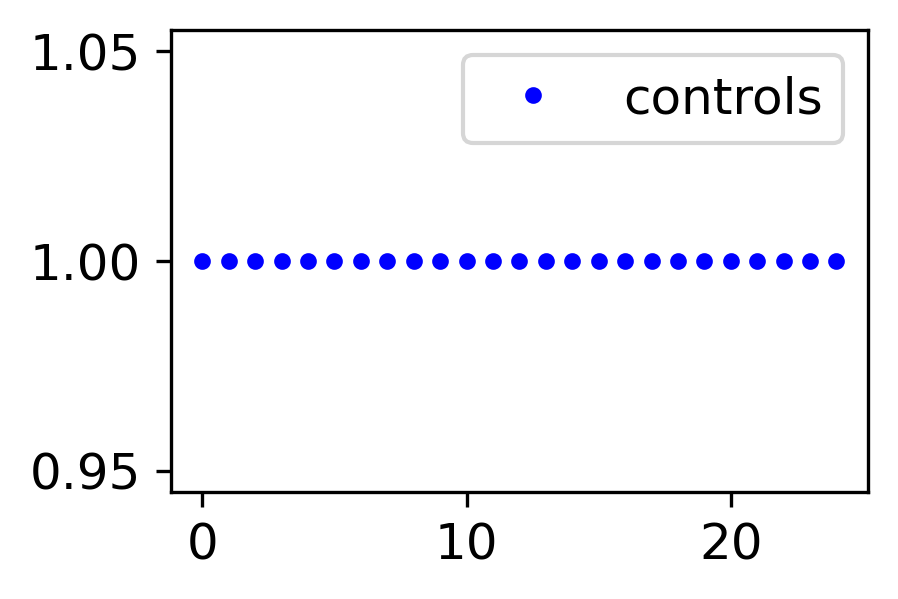

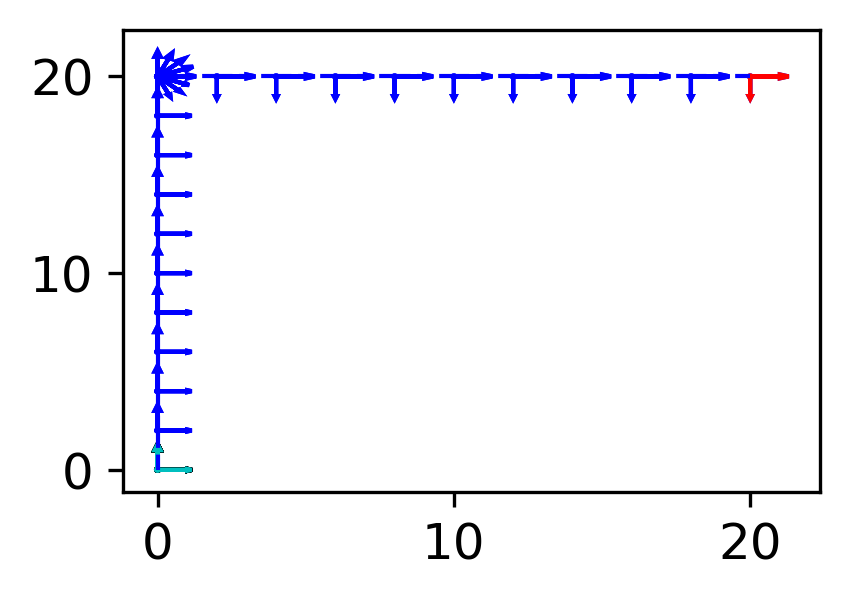

In [9]:
import copy 
from plot_feeg6043 import plot_2dframe, plot_path

# make matrices from time and twist lists
T_u = l2m(t_list)
U = l2m([v_list,w_list])

# initialise states
state = Vector(5)
X = state.T
t=copy.copy(T_u[0])

# counter to point to the next control timestep, flag to show an event just happend
idx = 0

# simulation in a while loop
while t <T_u[-1]:
    
    # calculate dt
    dt= T_u[idx] - t       
        
    # apply the model with to progress to dt with old control values
    state, F = motion_model(state, U[idx:idx+1, :].T, dt)    
        
    # progress time and store state
    X = np.vstack((X, state.T))        
        
    t = T_u[idx]
    if idx != len(T_u): idx += 1
    
plt.plot(T_u,np.ones([len(T_u),1]),'b.',label='controls')
plt.legend(); plt.show()

# plot the path
P = X[:,0:3]
plot_path(P, legend_flag = False, verbose = False)
plt.show()

## <span style="color:red">3. Measurement update (posterior)</span>

Position and heading sensor measurements directly relate to the robot state (**see A2.1**):

\begin{align}
\mathbf{z}_{NE} = h_{NE}(\mathbf{x}_k) = \begin{cases}
    N_{k} &= N_{k} \\
    E_{k} &= E_{k} \\
    \gamma_{k} &= 0 \\
    \dot{x}_{k} &= 0 \\
    \dot{\gamma}_{k} &= 0
\end{cases}, \hspace{1cm}
\mathbf{z}_{\gamma} = h_{\gamma}(\mathbf{x}_k) = \begin{cases}
    N_{k} &= 0 \\
    E_{k} &= 0 \\
    \gamma_{k} &= \gamma_{k} \\
    \dot{x}_{k} &= 0 \\
    \dot{\gamma}_{k} &= 0
\end{cases}
\end{align}

The corresponding measurement Jacobians are obtained by taking the derivatives of each measurement model with respect to $\mathbf{x}$, giving:

\begin{align}
H_{k} &= \begin{bmatrix}
\frac{\partial h_0}{\partial N} & \frac{\partial h_0}{\partial E} & \dots & \frac{\partial h_0}{\partial \dot \gamma} \\
\frac{\partial h_1}{\partial N} & \frac{\partial h_1}{\partial E} & \dots & \frac{\partial h_1}{\partial \dot \gamma} \\
\vdots & \vdots & \ddots & \vdots\\
\frac{\partial h_4}{\partial N} & \frac{\partial h_4}{\partial E} & \dots & \frac{\partial h_2}{\partial \dot \gamma}\end{bmatrix}, \hspace{0.5cm} H_{NE} = \begin{bmatrix}
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\\end{bmatrix},  \hspace{0.5cm} H_{\gamma} = \begin{bmatrix}
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\\end{bmatrix} 
\end{align}

- **Task:** Implement the measurement models to return predicted measurements and measurement Jacobians

In [10]:
def h_g_update(x):
    z = Vector(5)
    z[G] = x[G]
    H = Matrix(5,5)
    H[G,G] = 1
    return z, H

def h_ne_update(x):
    z = Vector(5)
    z[N] = x[N]
    z[E] = x[E]
    H = Matrix(5,5)
    H[N,N] = 1
    H[E,E] = 1
    return z, H

### <span style="color:red">Create a set of measurements </span>

Test the implementation with a set of fake measurements, we'll introduce some timestamp measurement noise to make it more realistic. 

> t_g_list = [0,2,4,6,8,10,12,14,16,18,20,22,24]

> g_list = [0,0,0,0,0,0,45,90,90,90,90,90,90] *Need to be in radians
>
> t_ne_list = [6,16,22]
> n_list = [12,20,20]
> e_list = [0,4,16]

Start with uncertainties of 1deg for heading sensor and 1m for northings and eastings

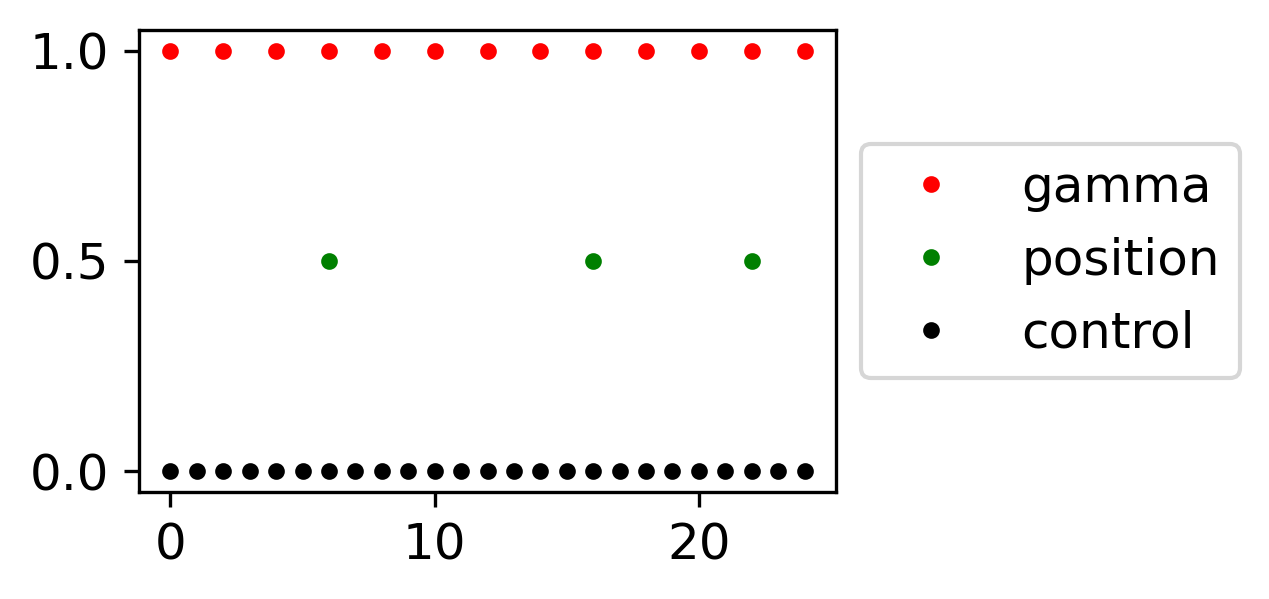

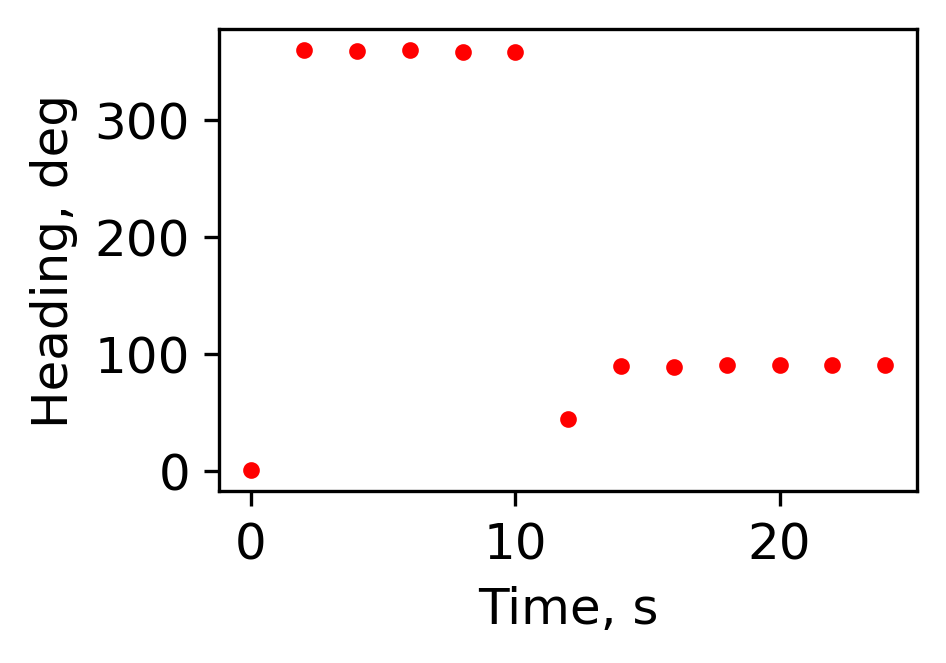

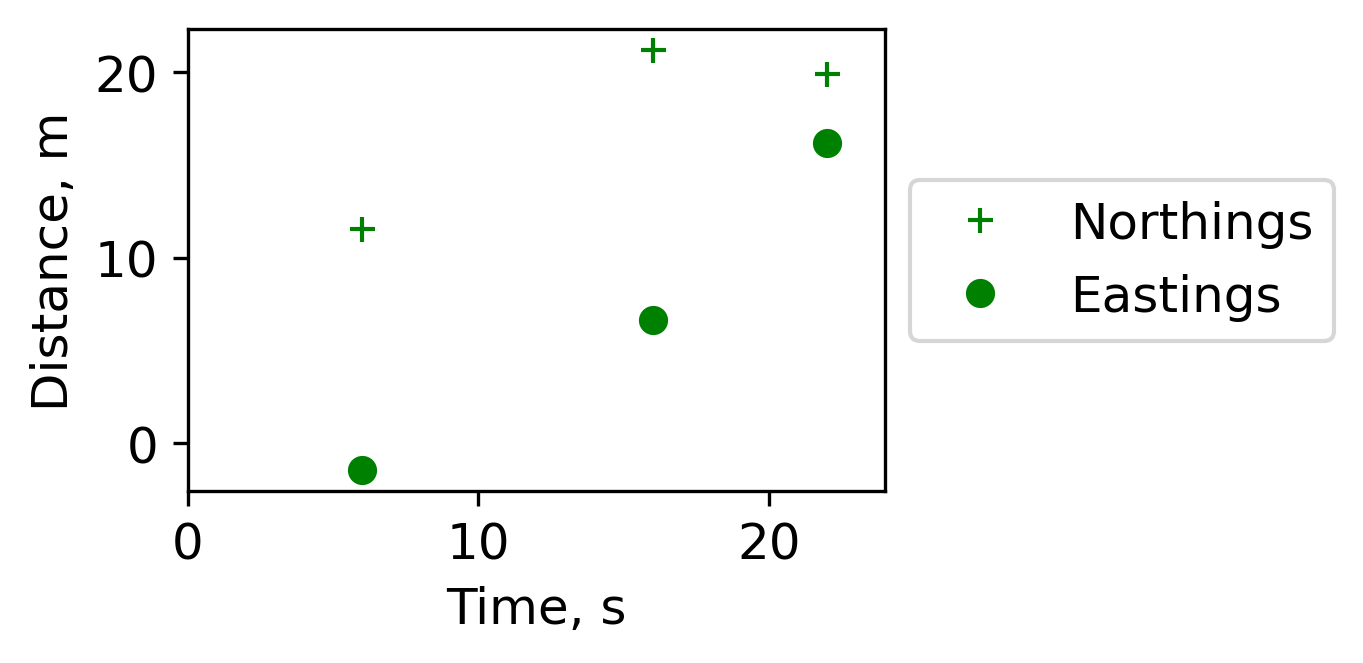

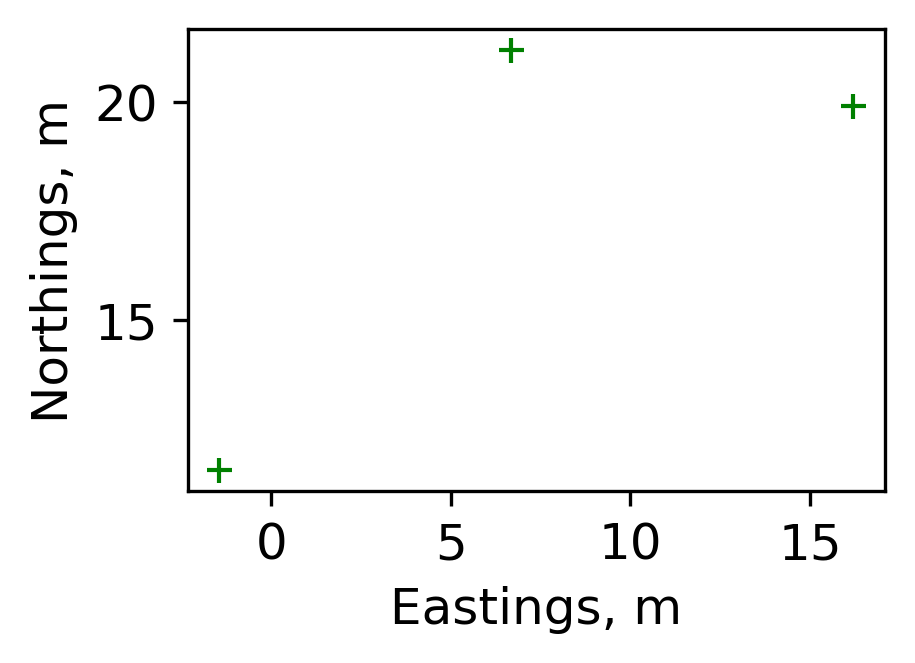

In [11]:
# create some fake heading sensor readings
t_g_list = [0,2,4,6,8,10,12,14,16,18,20,22,24] # times sensor readings were taken from in the heading
g_list = np.deg2rad([0,0,0,0,0,0,45,90,90,90,90,90,90]).tolist()
g_std = [np.deg2rad(1)] * len(g_list) #heading uncertainty of 1 degree

# create some fake position sensor readings
t_ne_list = [6,16,22] # times sensor readings were taken from in the NE
n_list = [12,20,20]
e_list = [0,4,16]
n_std = [1] * len(n_list)
e_std = [1] * len(e_list)

# add noise to make things more realistic
for i in range(len(t_g_list)): 
    g_list[i]=(g_list[i]+np.random.normal(0, g_std[i])) % (2*np.pi)

for i in range(len(t_ne_list)): 
    n_list[i]=n_list[i]+np.random.normal(0, n_std[i])
    e_list[i]=e_list[i]+np.random.normal(0, e_std[i])        


    
#create our matrices
Z_ne = l2m([n_list,e_list])
T_ne = l2m(t_ne_list)
Z_g = l2m([g_list])
T_g = l2m(t_g_list)
G_std = l2m(g_std)
NE_std = l2m([n_std,e_std])

plt.plot(T_g,np.ones([len(T_g),1]),'r.',label='gamma')
plt.plot(T_ne,0.5*np.ones([len(T_ne),1]),'g.',label='position')
plt.plot(T_u,0.*np.ones([len(U),1]),'k.',label='control')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); plt.show()

plt.plot(T_g,np.rad2deg(Z_g),'r.')
plt.xlabel('Time, s')
plt.ylabel('Heading, deg')
plt.show()

plt.plot(T_ne,Z_ne[:,0],'g+',label = 'Northings')
plt.plot(T_ne,Z_ne[:,1],'go',label = 'Eastings')
plt.xlabel('Time, s')
plt.ylabel('Distance, m')
plt.xlim([min(t_g_list),max(t_g_list)])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); plt.show()

plt.plot(Z_ne[:,1],Z_ne[:,0],'g+')
plt.xlabel('Eastings, m')
plt.ylabel('Northings, m')
plt.show()

## <span style="color:black">EKF for 2D robot motion</span>

Declare initial state (already in motion 2m/s going North from 0, 0) and initial covariances and process noise. Put in some sensible values below

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# from math_feeg6043 import Vector, Matrix, Identity, Inverse, eigsorted, gaussian, l2m
# from matplotlib.patches import Ellipse
from plot_feeg6043 import plot_kalman, plot_EKF_trajectory

init_state = Vector(5)
init_state[N] = 0
init_state[E] = 0
init_state[G] = 0
init_state[DOTX] = 0
init_state[DOTG] = 0

print('State:')
print(init_state)

# want the initial covariance to be the standard deviations since this is 
# represents our uncertainty
# the only reason they are squared is because you want a variance not a std deviation  
init_covariance = Identity(5) 
init_covariance[N,N] = NE_std[0,0]**2
init_covariance[E, E] = NE_std[0,1]**2
init_covariance[G, G] = G_std[0]**2
init_covariance[DOTX, DOTX] = 0.0**2
init_covariance[DOTG, DOTG] = np.deg2rad(0)**2

print('\nInitial state covariance:')
print(init_covariance)

R = Identity(5) 
R[N, N] = 0.0**2
R[E, E] = 0.0**2
R[G, G] = np.deg2rad(0.0)**2
R[DOTX, DOTX] = 0.01**2
R[DOTG, DOTG] = np.deg2rad(0.05)**2

print('\nProcess noise covariance:')
print(R)

State:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Initial state covariance:
[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 3.0461742e-04 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]

Process noise covariance:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e-04
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.61543549e-07]]


C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\1691303022.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  init_covariance[G, G] = G_std[0]**2


In the cell below, implement an EKF to fuse the velocity and orientation measurements generated above with our motion models and plots the resulting uncertainties
- **Task 1:** Run this first with just motion model predictions
- **Task 2:** Modify the control to have a tiny w element (checking exception case of the motion models agree with the main model, need to modify a few cells up)
- **Task 3:** Add all heading measurements (Hint: Important aspect is to handle angle wrapping, check what happens if you don't)
- **Task 4:** Add all position measurement
- **Task 5:** Turn the trajectory into a complete box, and run with only motion model and with the full updates (does the pattern make sense?)

C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3581762192.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[G, G] = G_std[g_idx:g_idx+1]**2
C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3751406531.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[N, G] = -DOTX_k * dt *np.sin(G_k_1)
C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3751406531.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[N, DOTX] = dt * np.cos(G_k_1)
C:\Users\maxim\AppData\

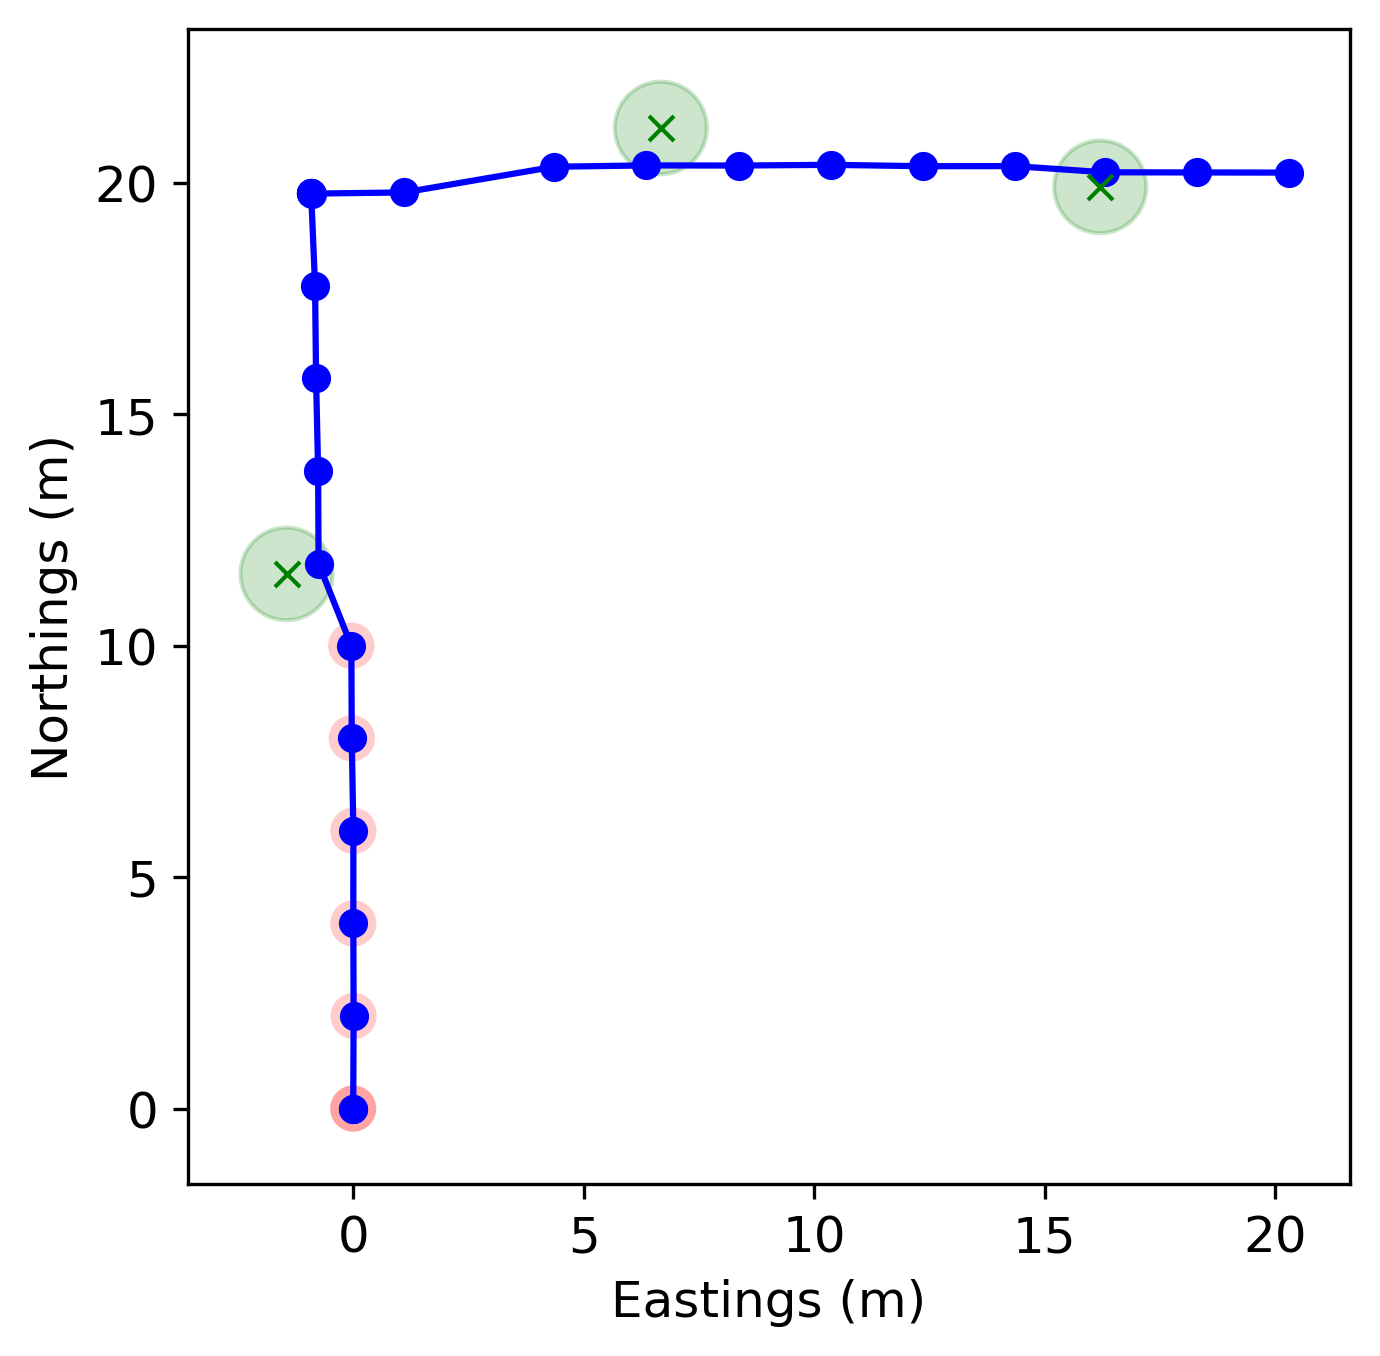

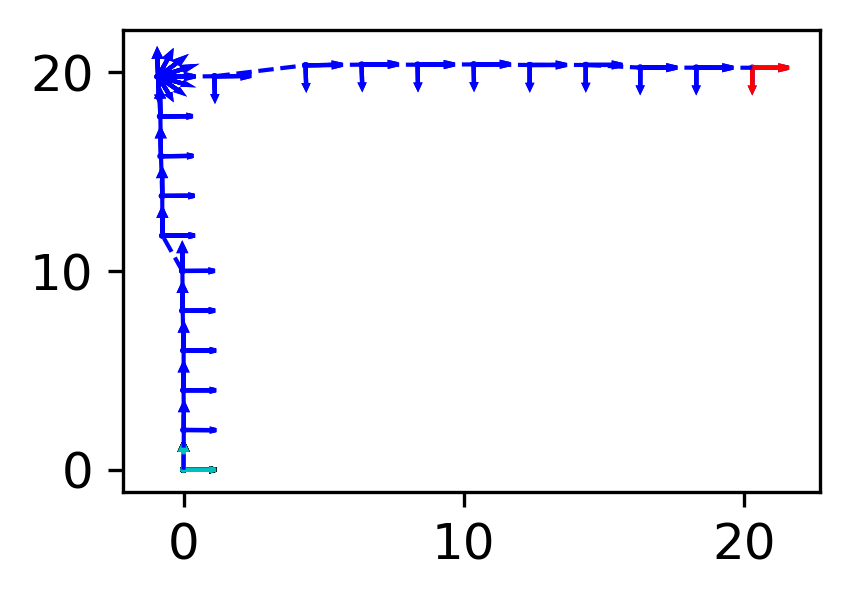

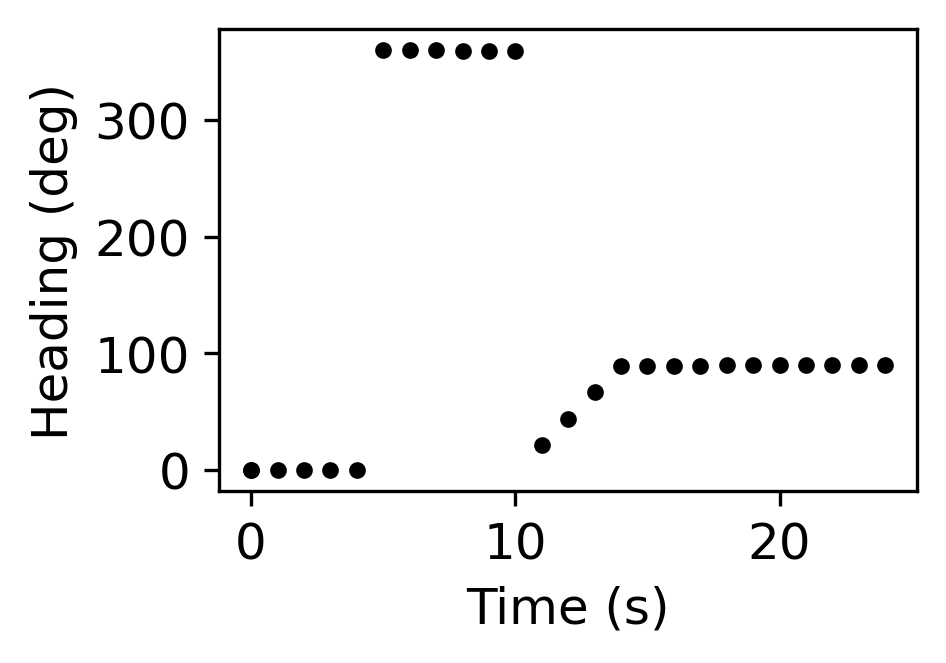

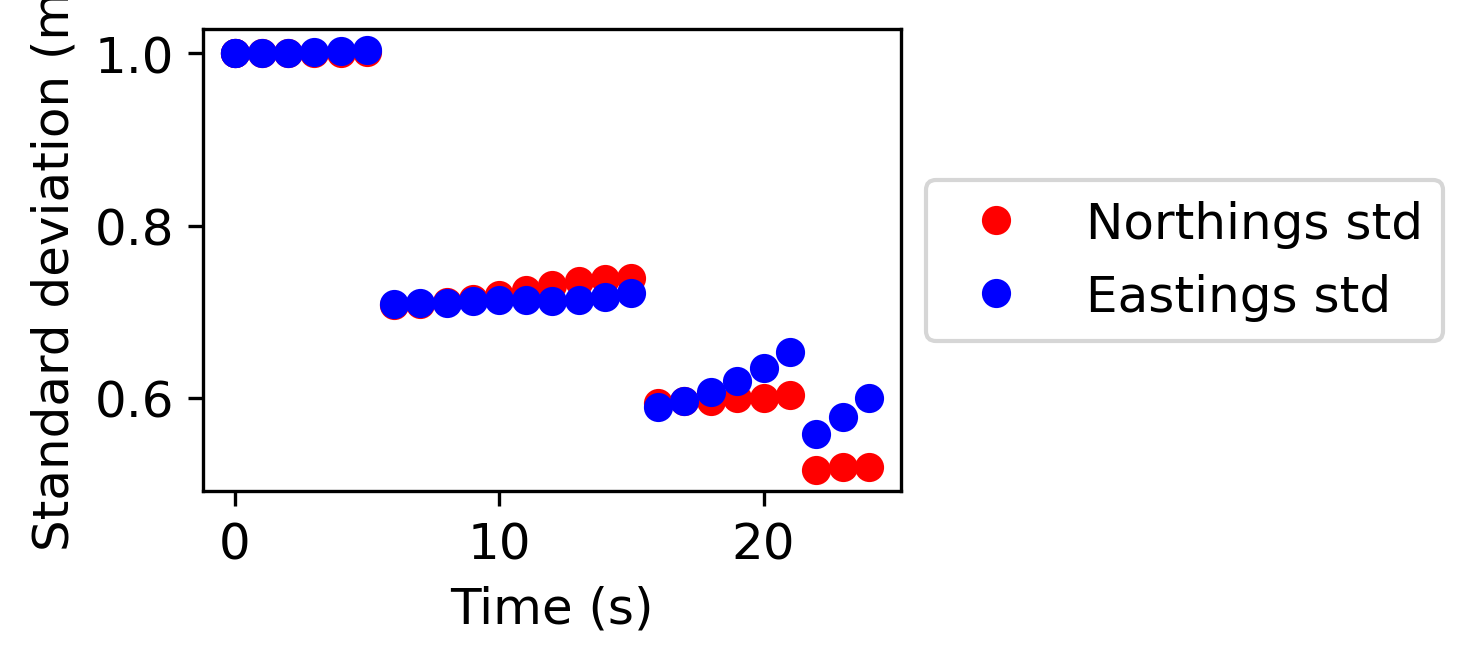

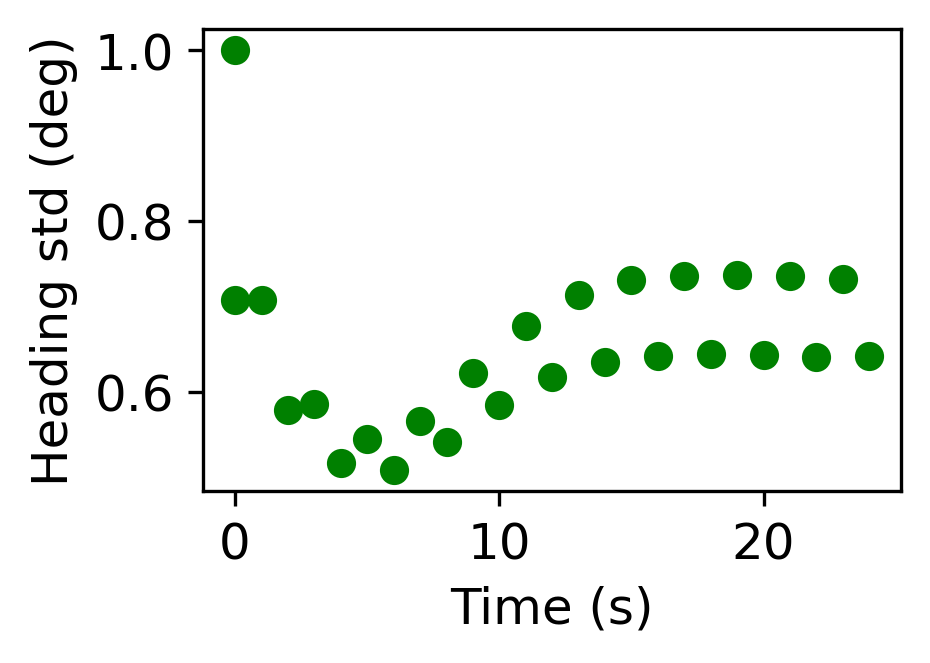

In [13]:
# initial state and covariance
state = init_state
covariance = init_covariance

# containors to store the data
X = state.T
COV = covariance.T

# containors for control and measyrenebts

# define pointers for our control and measurement data
u_idx = 0
g_idx = 0
ne_idx = 0

# get initial and timestamp and create containor to store times
t_prev=np.min([T_u[0],T_g[0],T_ne[0]])
t_end=np.max([T_u[-1],T_g[-1],T_ne[-1]]) 
T = Vector(1)
T[0,0] = t_prev

#################################################################
# Main simulation loop
#################################################################
while t_prev < t_end:    
    
    # Check which timestamp to process first
    next_stamp = None
    u_stamp = None
    g_stamp = None
    ne_stamp = None 
          
    if u_idx < len(T_u):
        u_stamp = T_u[u_idx]

    if g_idx < len(T_g):
        g_stamp = T_g[g_idx]

    if ne_idx < len(T_ne):
        ne_stamp = T_ne[ne_idx]     
    
    potential_stamps = [
        u_stamp,
        g_stamp,
        ne_stamp        
    ]
        
    valid_stamps = [i for i in potential_stamps if i is not None]
    
    if valid_stamps:
        t = min(valid_stamps) 
    else:
        break  # If there is no timestep left to predict to, simulation finishes
    
    dt = t - t_prev
    
    if t == u_stamp:
            u = U[u_idx:u_idx+1,:].T
            u_idx += 1
            
    if dt != 0:                              
        state, covariance = extended_kalman_filter_predict(state, covariance, u, motion_model, R, dt)

    if t == g_stamp: 
        z = Vector(5)
        Q = Identity(5)        
        
        h = h_g_update
        z[G] = Z_g[g_idx:g_idx+1,:]

        Q[G, G] = G_std[g_idx:g_idx+1]**2
        if g_idx < len(T_g): g_idx+=1 
        
        #Task 3
        #these are the updates
        state, covariance = extended_kalman_filter_update(state, covariance, z, h, Q, wrap_index = G)      

        
    # position updatee
    if t == ne_stamp: 
        z = Vector(5)
        Q = Identity(5)        
        
        h = h_ne_update
        z[N] = Z_ne[ne_idx:ne_idx+1,:][0,0]
        z[E] = Z_ne[ne_idx:ne_idx+1,:][0,1]

        Q[N, N] = NE_std[ne_idx:ne_idx+1,:][0,0]**2
        Q[E, E] = NE_std[ne_idx:ne_idx+1,:][0,1]**2
        
        if ne_idx < len(T_ne): ne_idx+=1 
    
    
        #these are the updates
        state, covariance = extended_kalman_filter_update(state, covariance, z, h, Q)      

  
    X = np.vstack((X,state.T))
        
    COV = np.vstack((COV,covariance.T))
    T = np.vstack((T,t))
        
    t_prev = t
    
    
plot_EKF_trajectory(X, COV, flip=True, measurements = [Z_ne, NE_std], keyframe = 1)


P = X[:,0:3]
plot_path(P, legend_flag = False, verbose = False)

# plot the heading as a function of time
heading = []

for i in range(len(T)): 
    heading.append(X[i,G])

plt.figure()
plt.plot(T, np.rad2deg(heading), 'k.')
plt.xlabel("Time (s)")
plt.ylabel("Heading (deg)")
plt.show()
   
# plot the uncertainties as a function of time
n_std = []
e_std = []
g_std = []
j = len(state)

for i in range(len(T)):    
    n_std.append(np.sqrt(COV[i*j+N,N]))
    e_std.append(np.sqrt(COV[i*j+E,E]))
    g_std.append(np.rad2deg(np.sqrt(COV[i*j+G,G])))

plt.figure()
plt.plot(T, n_std, 'ro', label='Northings std')
plt.plot(T, e_std, 'bo', label='Eastings std')
plt.xlabel("Time (s)")
plt.ylabel("Standard deviation (m)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


plt.figure()
plt.plot(T, g_std, 'go')
plt.xlabel("Time (s)")
plt.ylabel("Heading std (deg)")
plt.show()

Cell below repeats the control assignment from earlier, modify this in task 2 and run the cell above again

C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3751406531.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[N, G] = -DOTX_k * dt *np.sin(G_k_1)
C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3751406531.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[N, DOTX] = dt * np.cos(G_k_1)
C:\Users\maxim\AppData\Local\Temp\ipykernel_25884\3751406531.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[E, G] = DOTX_k * dt * np.cos(G_k_1)
C:\Users\maxim\AppD

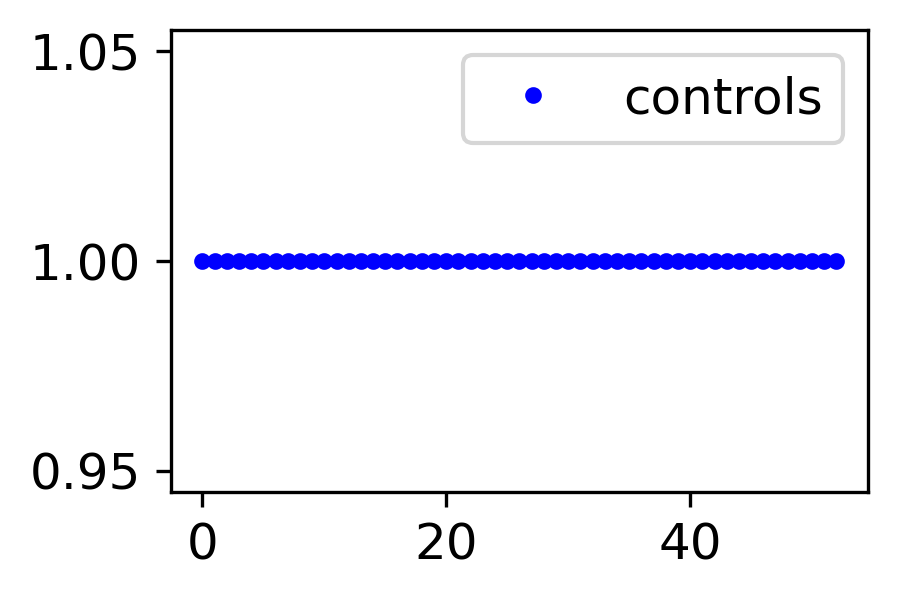

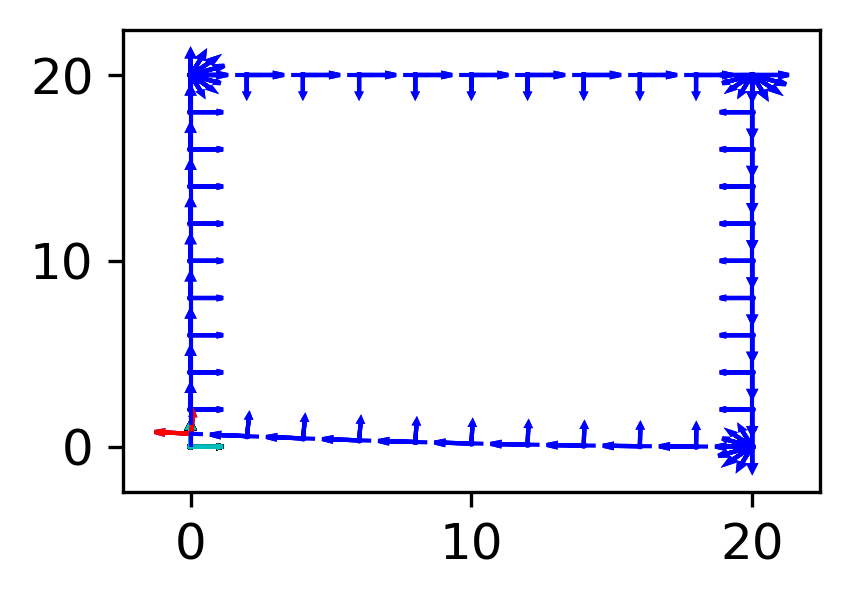

In [14]:
start = 0
end = 52
timestep = 1 #s
num_points = int( end / timestep )+1
t_list = np.linspace(start, end, num_points)
v_list = []
w_list = []
for i in range(len(t_list)):
    if t_list[i] <= 10:
        v_list.append(2)
        w_list.append(np.deg2rad(0))
    elif t_list[i] <= 14:
        v_list.append(0)
        w_list.append(np.deg2rad(90/4))

    elif t_list[i] <= 24:
        v_list.append(2)
        w_list.append(np.deg2rad(0))

    elif t_list[i] <= 28:
        v_list.append(0)
        w_list.append(np.deg2rad(90/4))
    elif t_list[i] <= 38:
        v_list.append(2)
        w_list.append(np.deg2rad(0))
        
    elif t_list[i] <= 42:
        v_list.append(0)
        w_list.append(np.deg2rad(90/4))

    else:
        v_list.append(2)
        w_list.append(np.deg2rad(0.4))   
    
T_u = l2m(t_list)
U = l2m([v_list,w_list])

# initialise states
state = Vector(5)
X = state.T
t=copy.copy(T_u[0])

# counter to point to the next control timestep, flag to show an event just happend
idx = 0


# simulation in a while loop
while t <T_u[-1]:
    
    # calculate dt
    dt= T_u[idx] - t       
        
    # apply the model with to progress to dt with old control values
    state, F = motion_model(state, U[idx:idx+1,:].T, dt)    
        
    # progress time and store state
    X = np.vstack((X, state.T))        
        
    t = T_u[idx]
    if idx != len(T_u): idx += 1
 
    
# plot the path
P = X[:,0:3]

plt.plot(T_u,np.ones([len(T_u),1]),'b.',label='controls')
plt.legend(); plt.show()

plot_path(P, legend_flag = False, verbose = False)
plt.show()

## <span style="color:blue"> Wrap up</span>

You should now:

- Understand how uncertainty modelling is achieved in the EKF, and the impact of process and measurement noise parameters
- Be able to implement and apply an EKF to a simple robotic scenario